# Calibration in wavelength of the  spectra of CTIO Data June 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- date   : Jun 2017


In [4]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [5]:
print theNotebook

CalibrateSpectrum


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
import sys
sys.path.append("../../common_tools/")
from scan_holo import *

In [11]:
!ls ../../common_tools/

data             holo_specs.pyc   scan_holo.pyc
fwhm_profiles.py pictures         targets.py
holo_specs.py    scan_holo.py     tools.py


In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [16]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [17]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [18]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [19]:
inputdir="./spectrum_fitsspec"
MIN_IMGNUMBER=208  # skip the 58 which is not at the right place
MAX_IMGNUMBER=284
object_name='HD205905 May 30 2017th'
SelectTagRe='^finalSpectra_20170530_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^finalSpectra_20170530_[0-9]+.fits$'
NBIMGPERROW=2

### Output fits file

In [20]:
outputdir="./spectrum_calibspec"

In [21]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [22]:
input_filelist=os.listdir(inputdir) 

In [23]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [24]:
print input_filelist[0:5]

['finalSpectra_20170530_210.fits' 'finalSpectra_20170530_211.fits'
 'finalSpectra_20170530_212.fits' 'finalSpectra_20170530_213.fits'
 'finalSpectra_20170530_214.fits']


In [25]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [26]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [27]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [28]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [29]:
print indexes_files

[210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284]


In [30]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [31]:
sorted_numbers=indexes_files[sorted_indexes]

In [32]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]


In [33]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [34]:
sorted_files[0:5]

array(['./spectrum_fitsspec/finalSpectra_20170530_210.fits',
       './spectrum_fitsspec/finalSpectra_20170530_211.fits',
       './spectrum_fitsspec/finalSpectra_20170530_212.fits',
       './spectrum_fitsspec/finalSpectra_20170530_213.fits',
       './spectrum_fitsspec/finalSpectra_20170530_214.fits'], 
      dtype='|S50')

## Build full filename
----------------------------

In [35]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [36]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [37]:
print sorted_filenames.shape

(75,)


## Acces to spectrum data
----------------------------------

In [38]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        filters = header['FILTERS'].split(' ')[1]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_filt

In [39]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_filt=BuildRawSpec(sorted_files,sorted_numbers,object_name)

In [40]:
print all_filt

['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']


## Show Spectra
-----------------------

In [41]:
len(all_rightspectra)

75

In [42]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
import math as m


from matplotlib.backends.backend_pdf import PdfPages

def ShowSpectra(all_spectra,all_titles,object_name,dir_top_img,all_filt,figname):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    
    NBIMGPERROW=2
    NBSPEC=len(all_spectra)
    
    MAXIMGROW=max(2,int(m.ceil(float(NBSPEC)/float(NBIMGPERROW))))
    
    
    # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_img,figname)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    title='Raw 1D Spectra 1D for {}'.format(object_name)
    
    
      
    for index in np.arange(0,NBSPEC):
        
        
        # new pdf page    
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20)
            
        # index of image in the pdf page    
        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
    
  
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
       
        axarr[iy,ix].grid(True)
      
        max_y_to_plot=spectrum[:].max()*1.2
        
        axarr[iy,ix].set_ylim(0.,max_y_to_plot)
        axarr[iy,ix].text(0.,max_y_to_plot*1.1/1.2, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
    
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()    
    

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


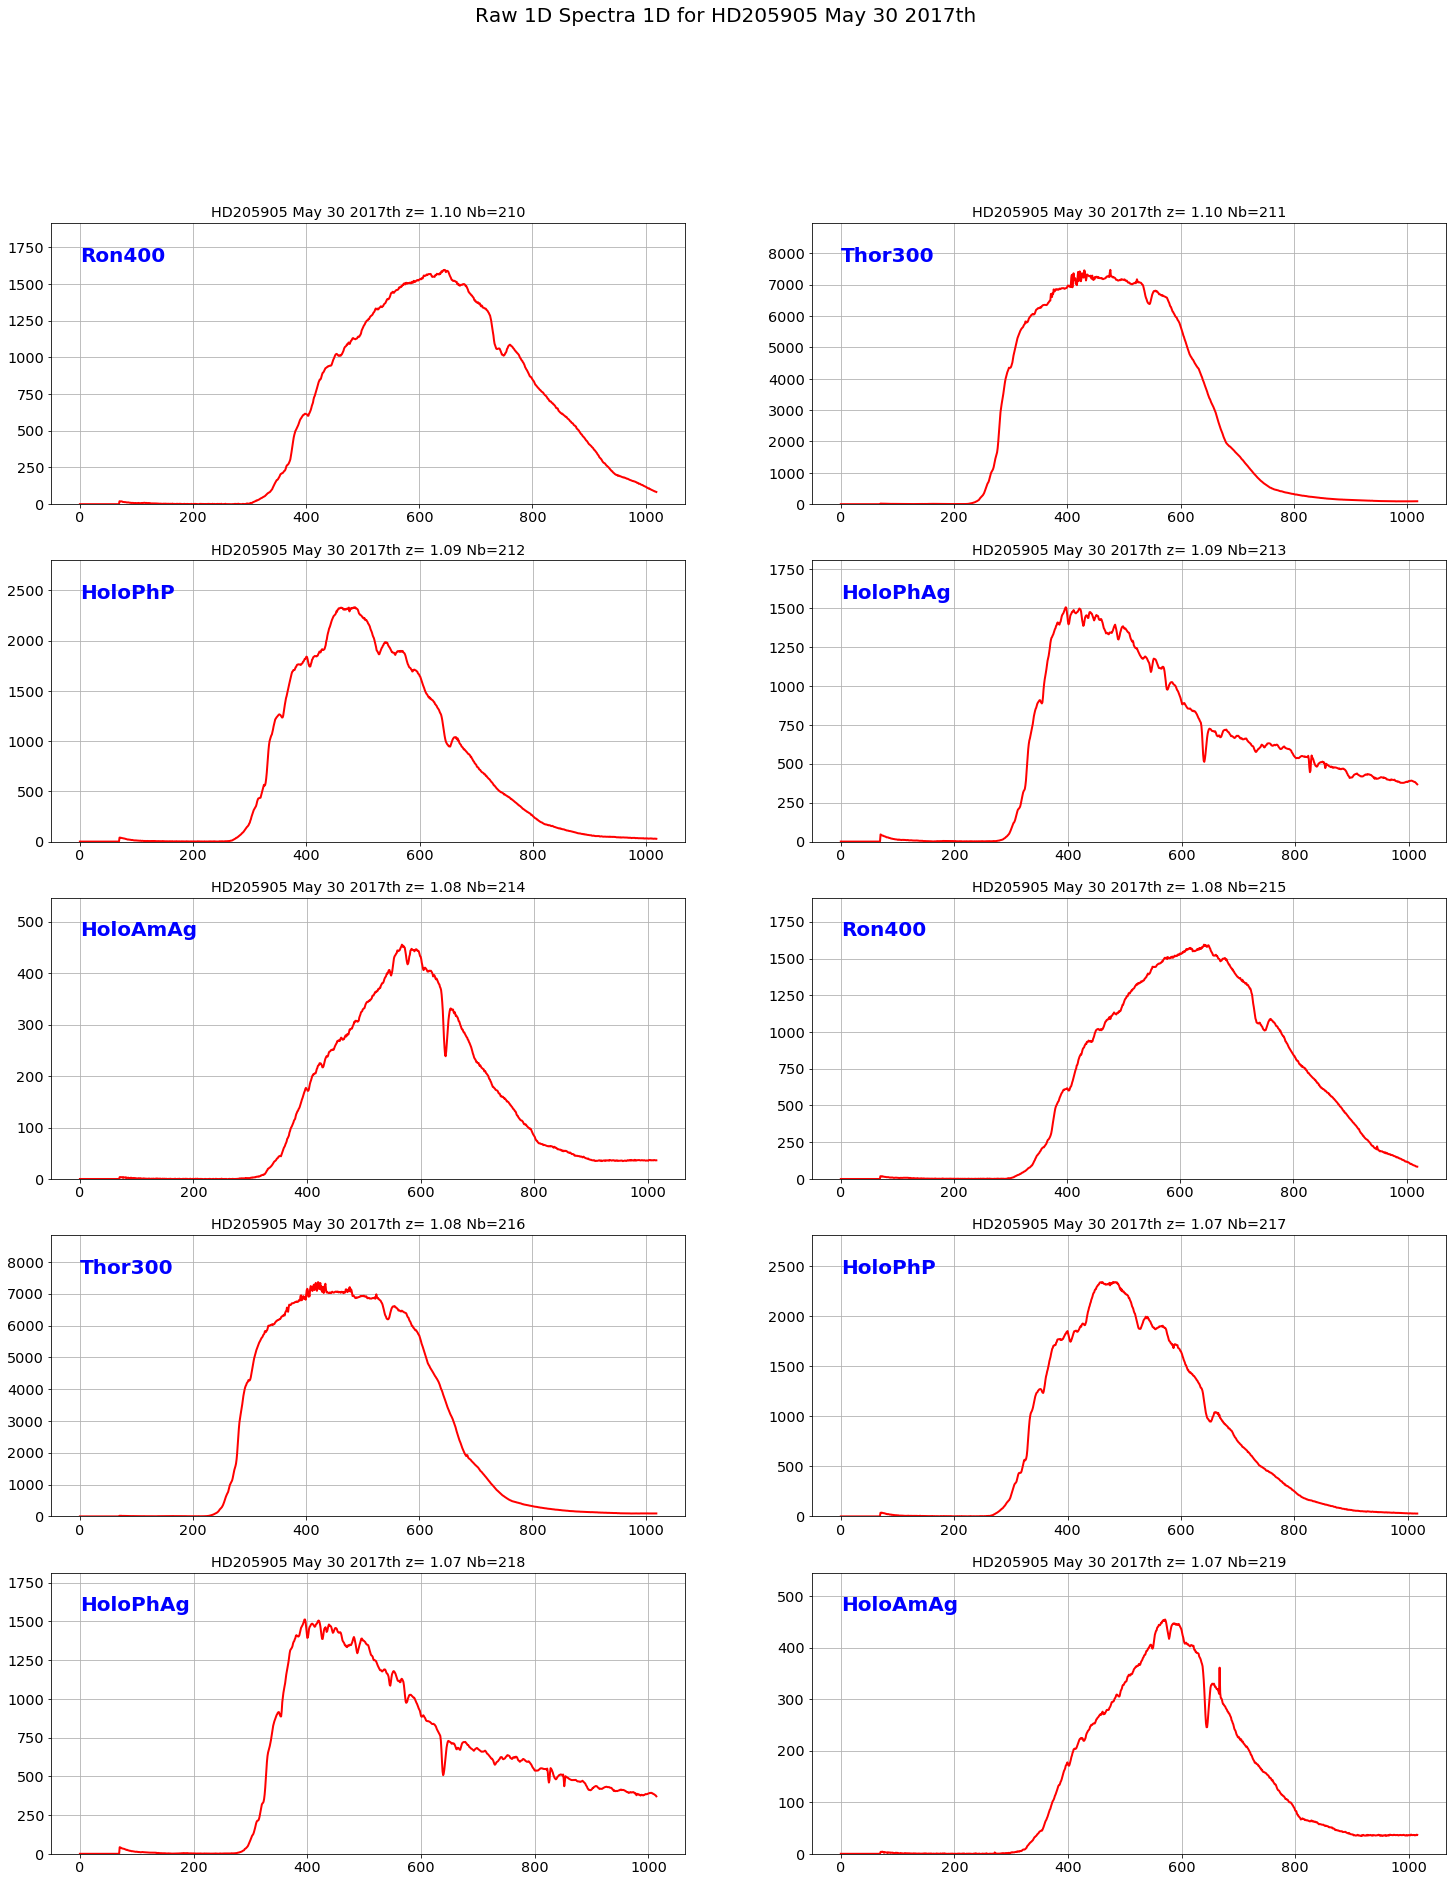

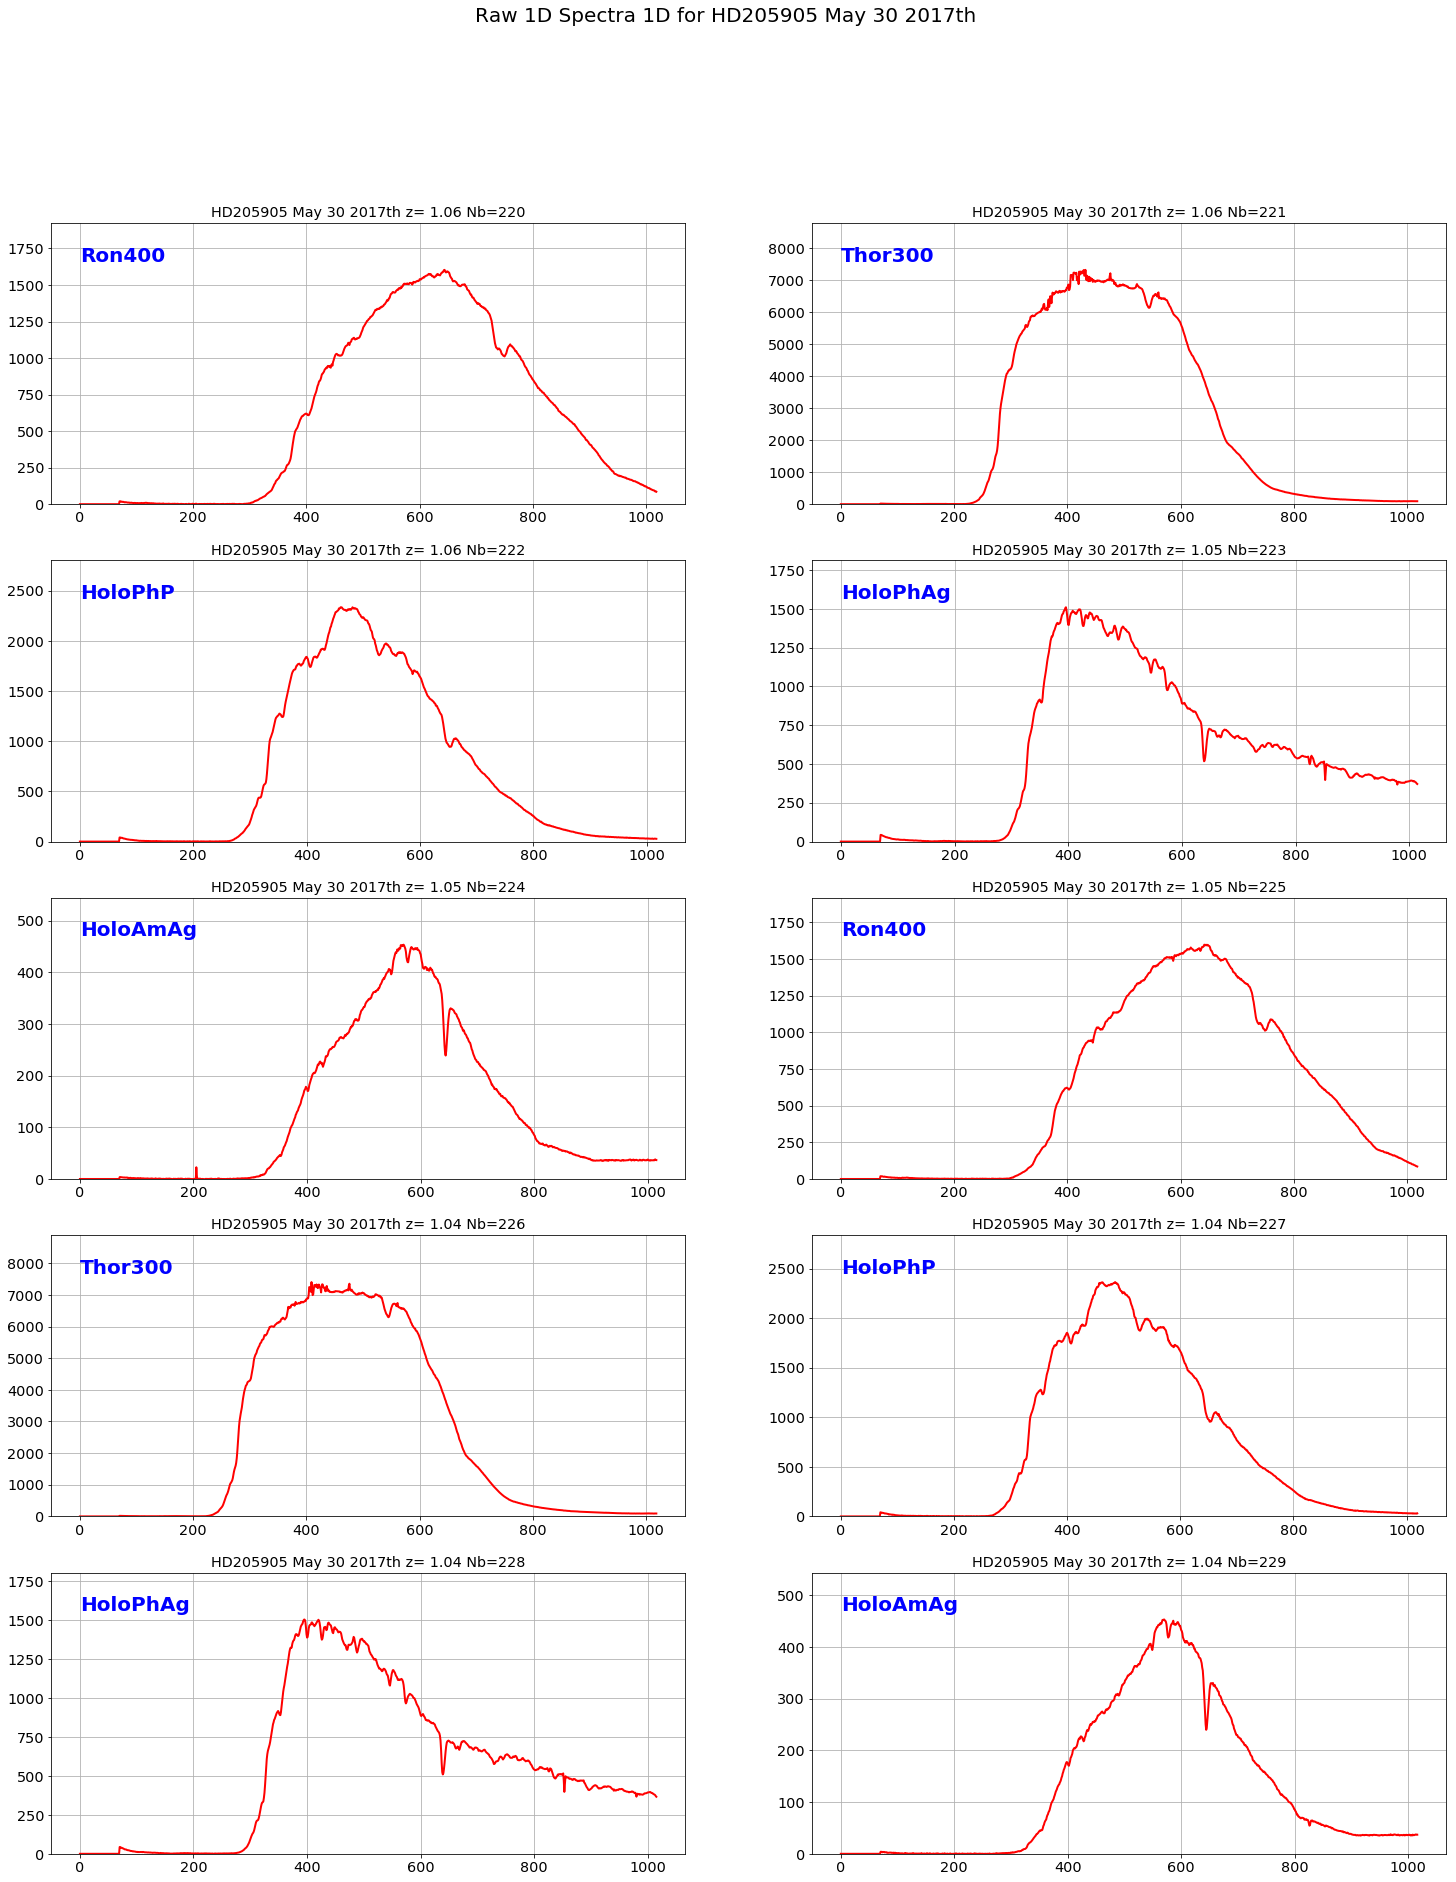

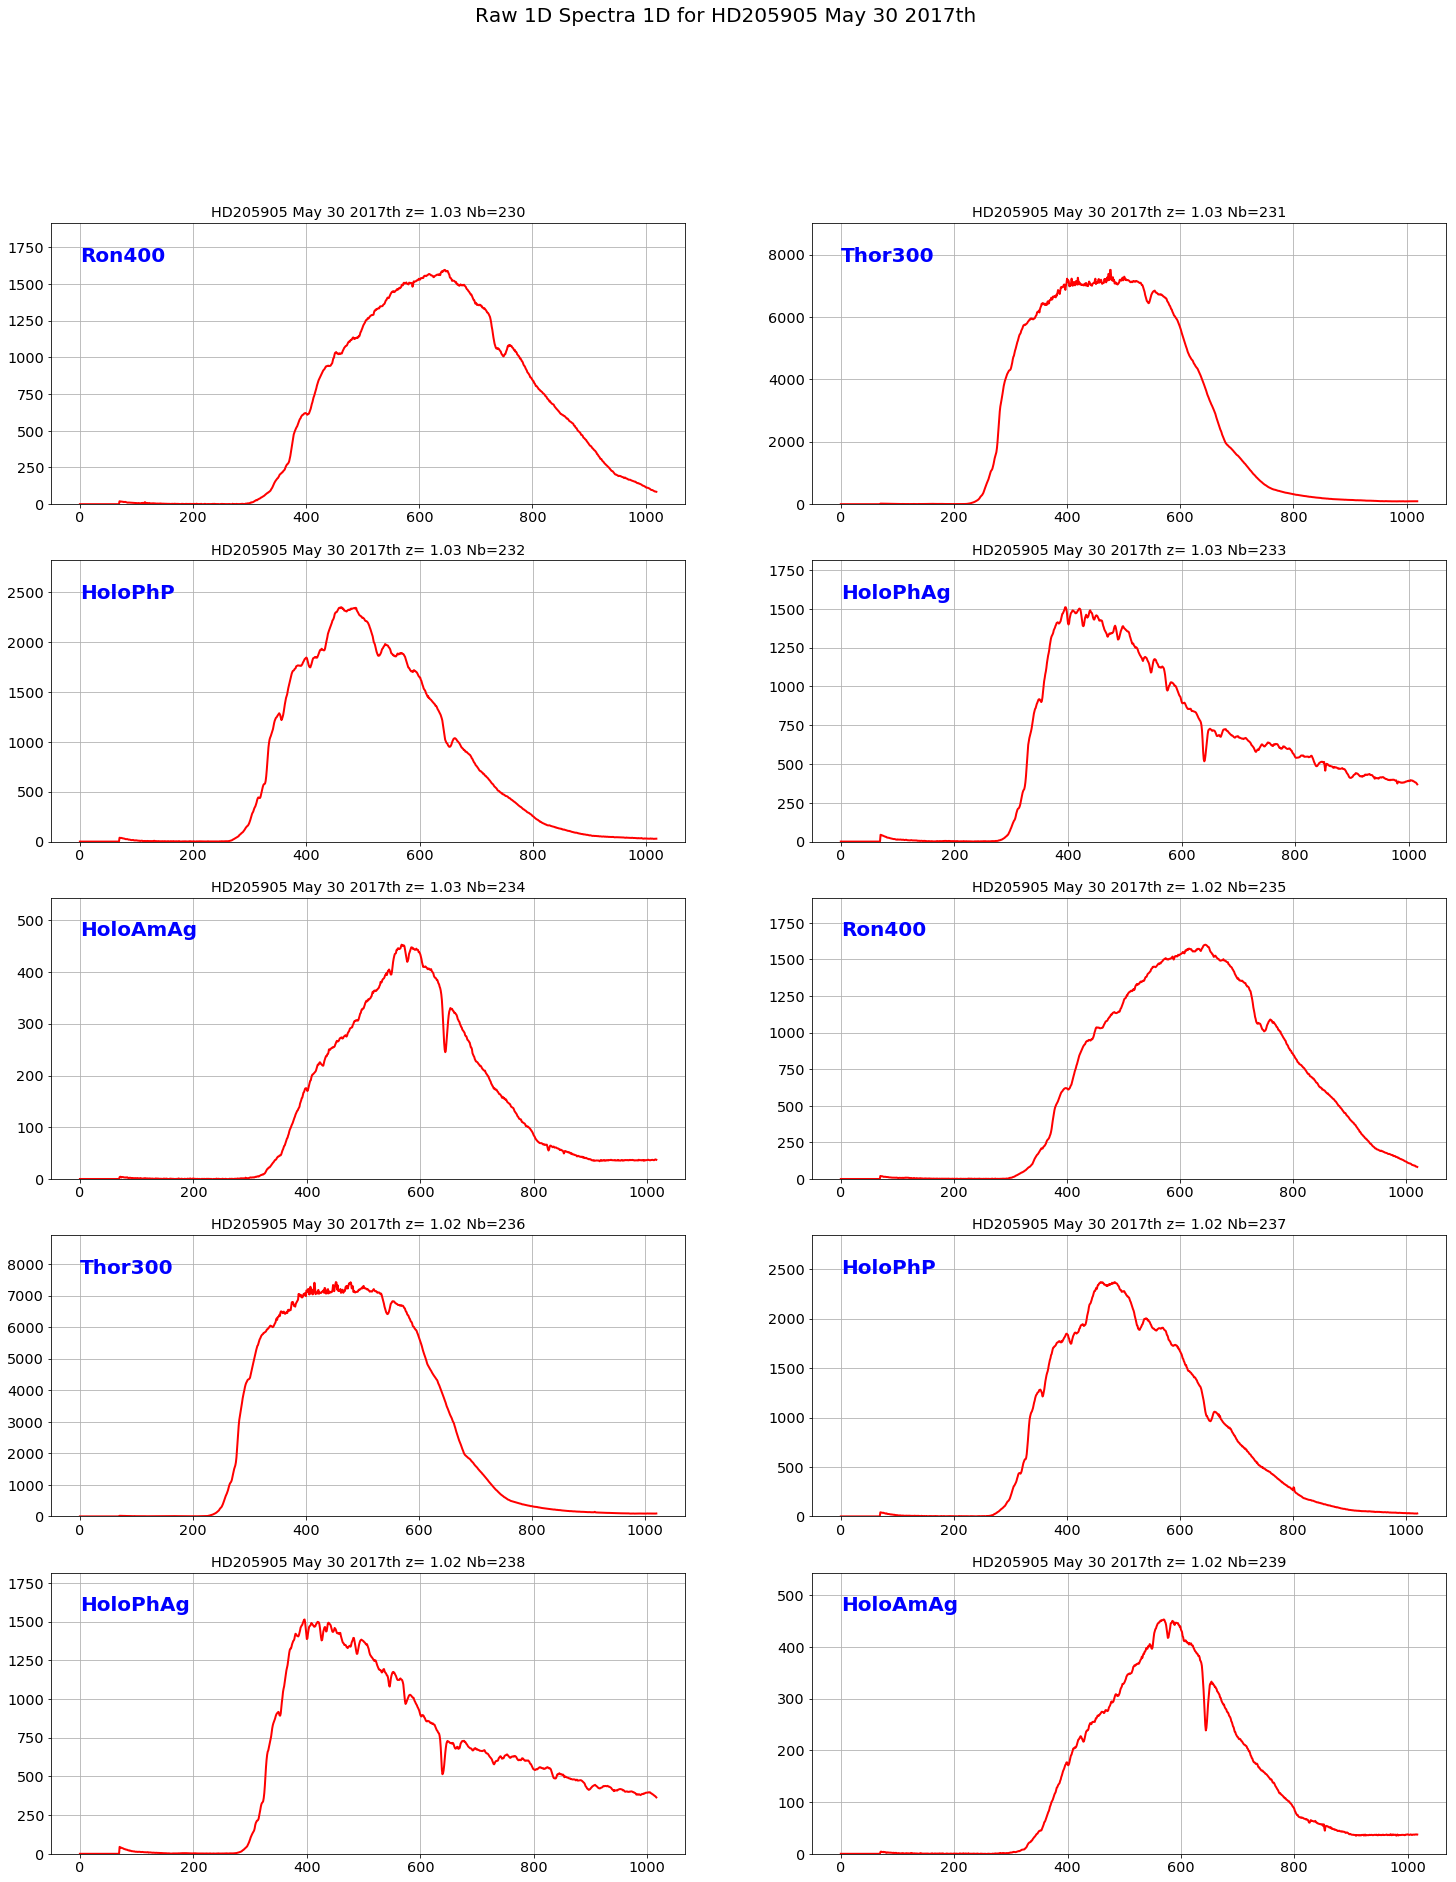

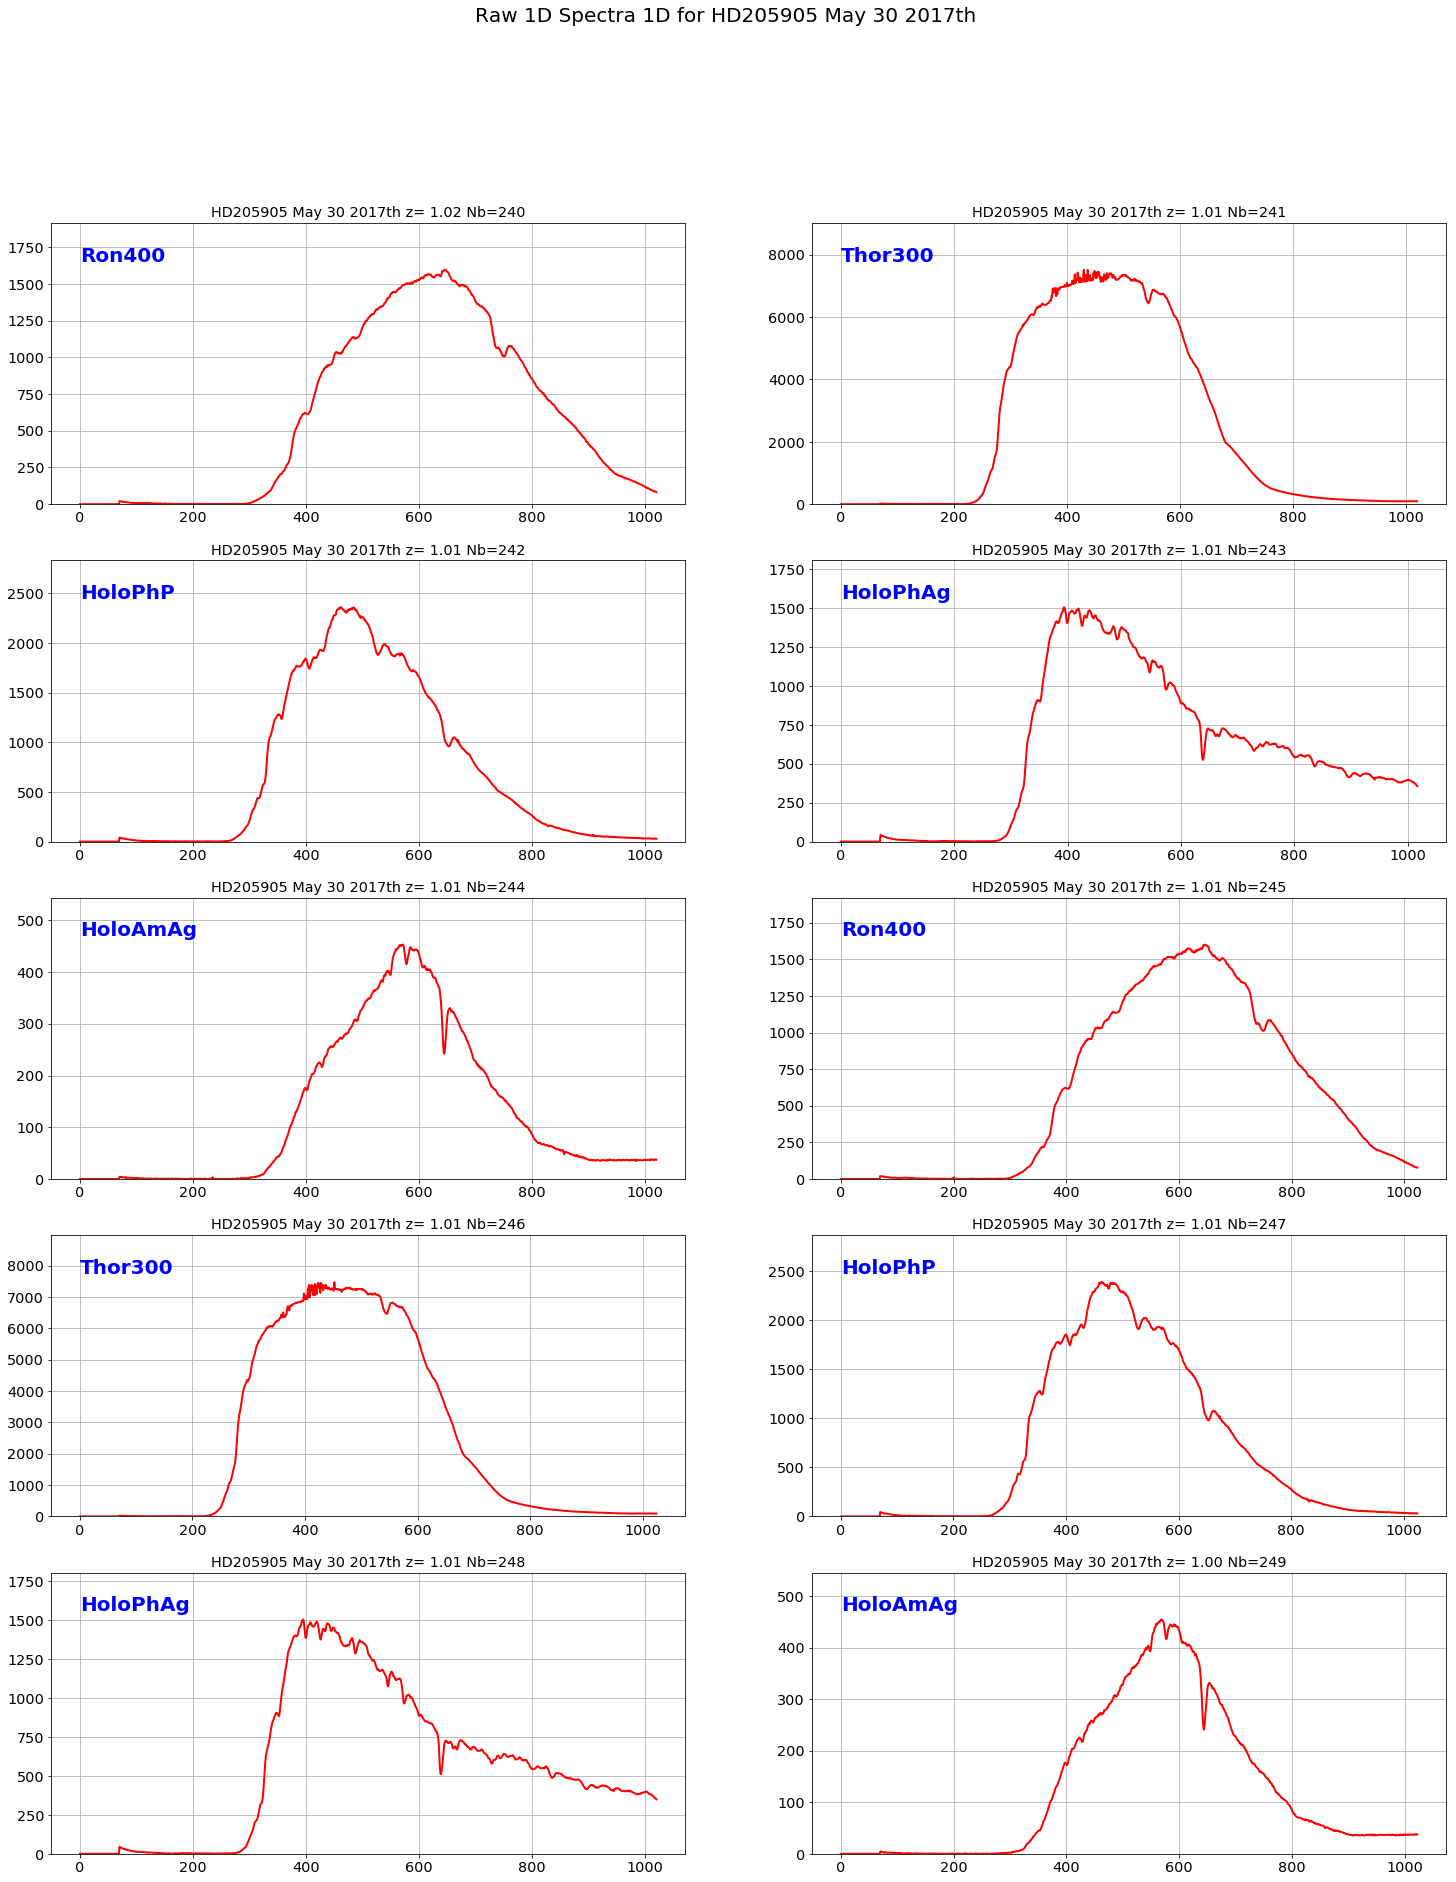

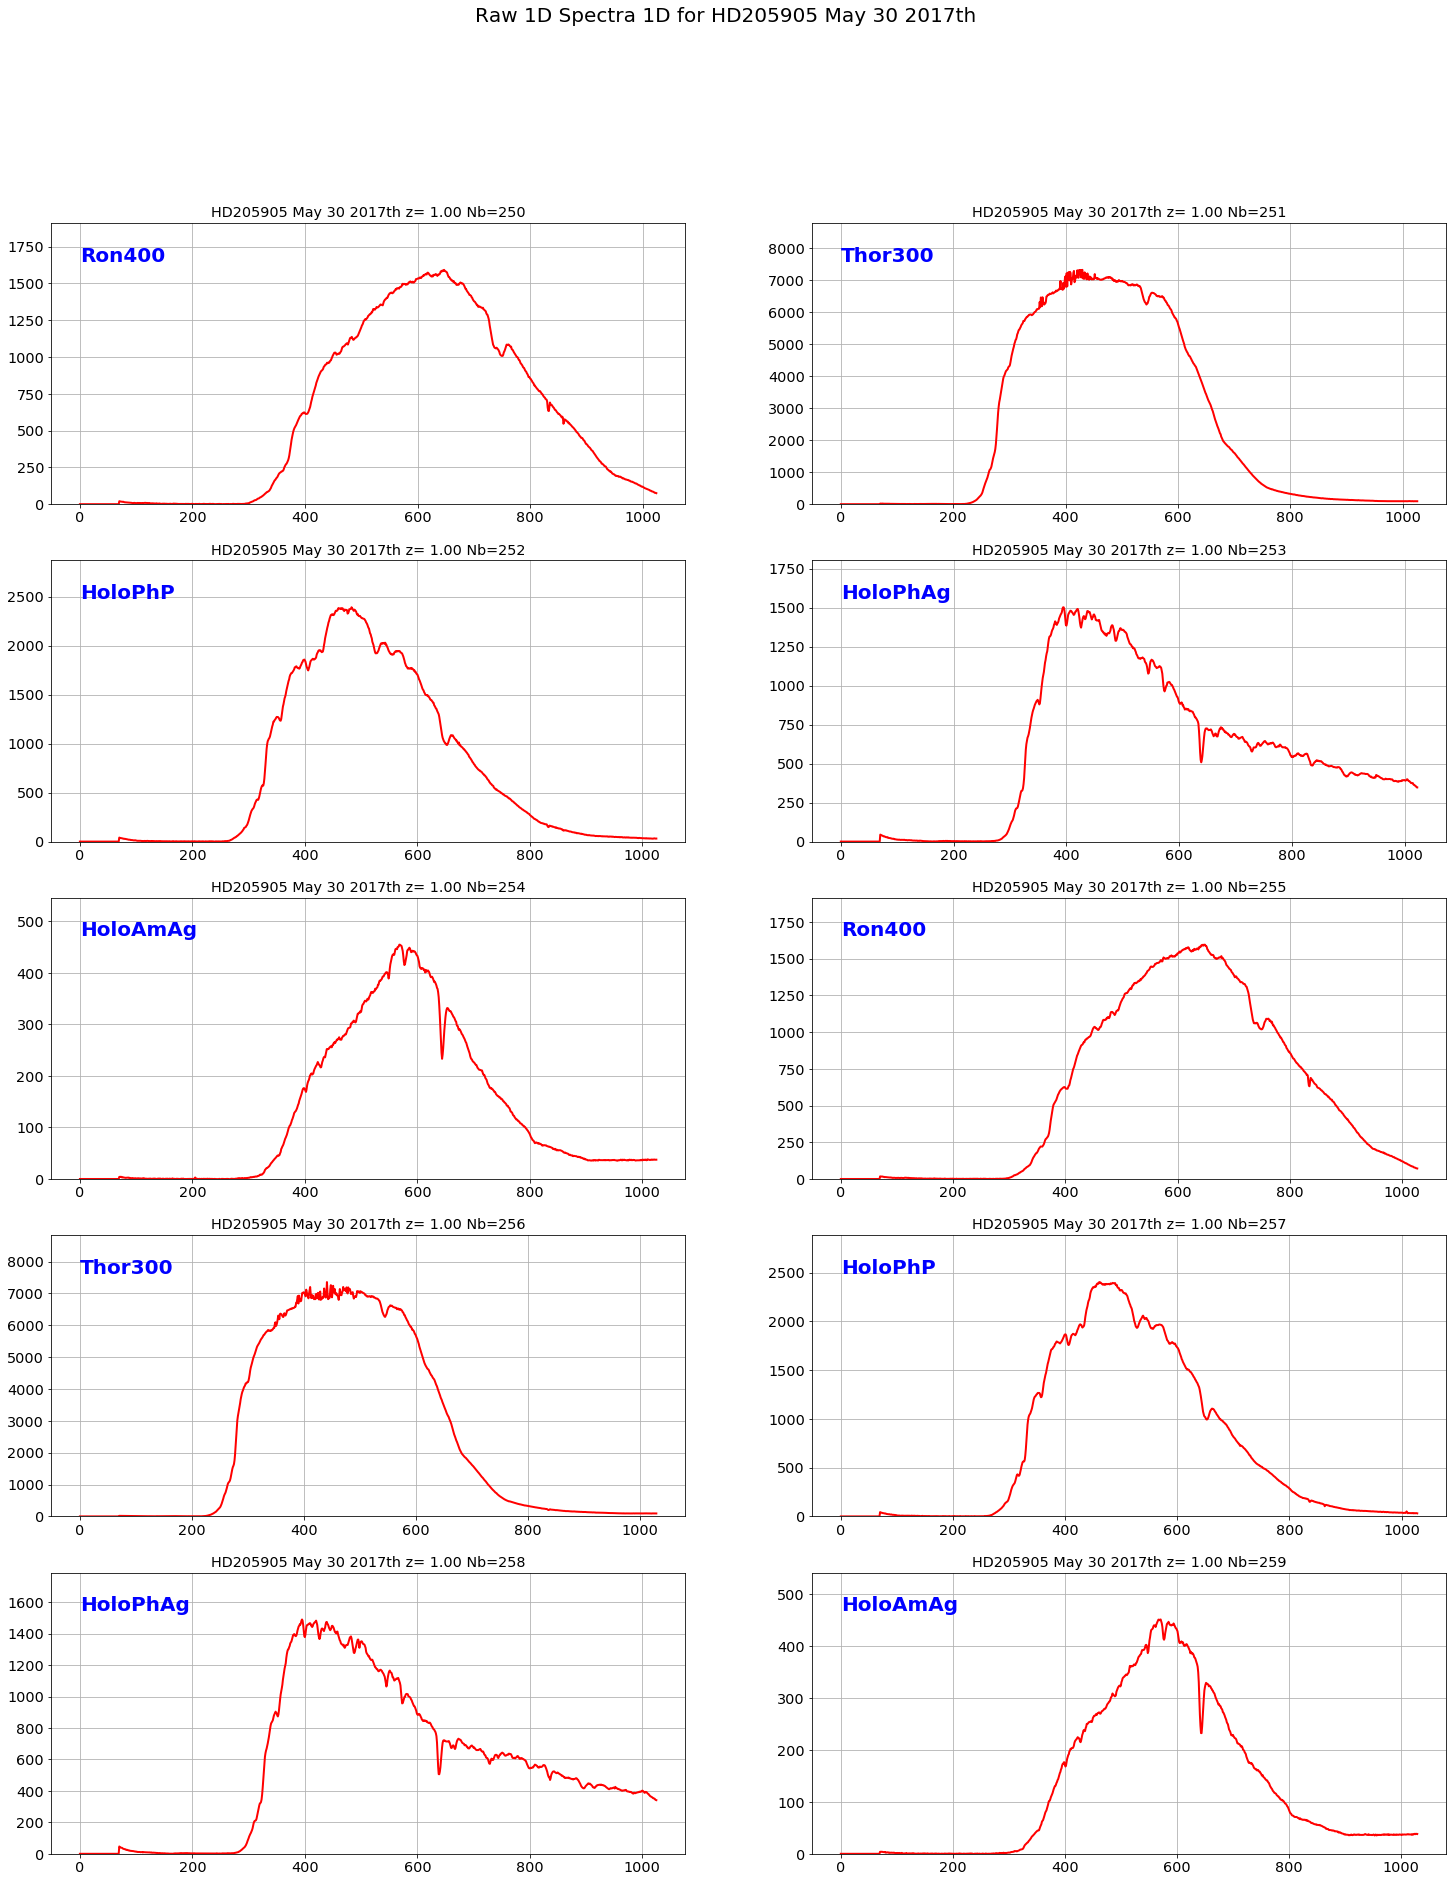

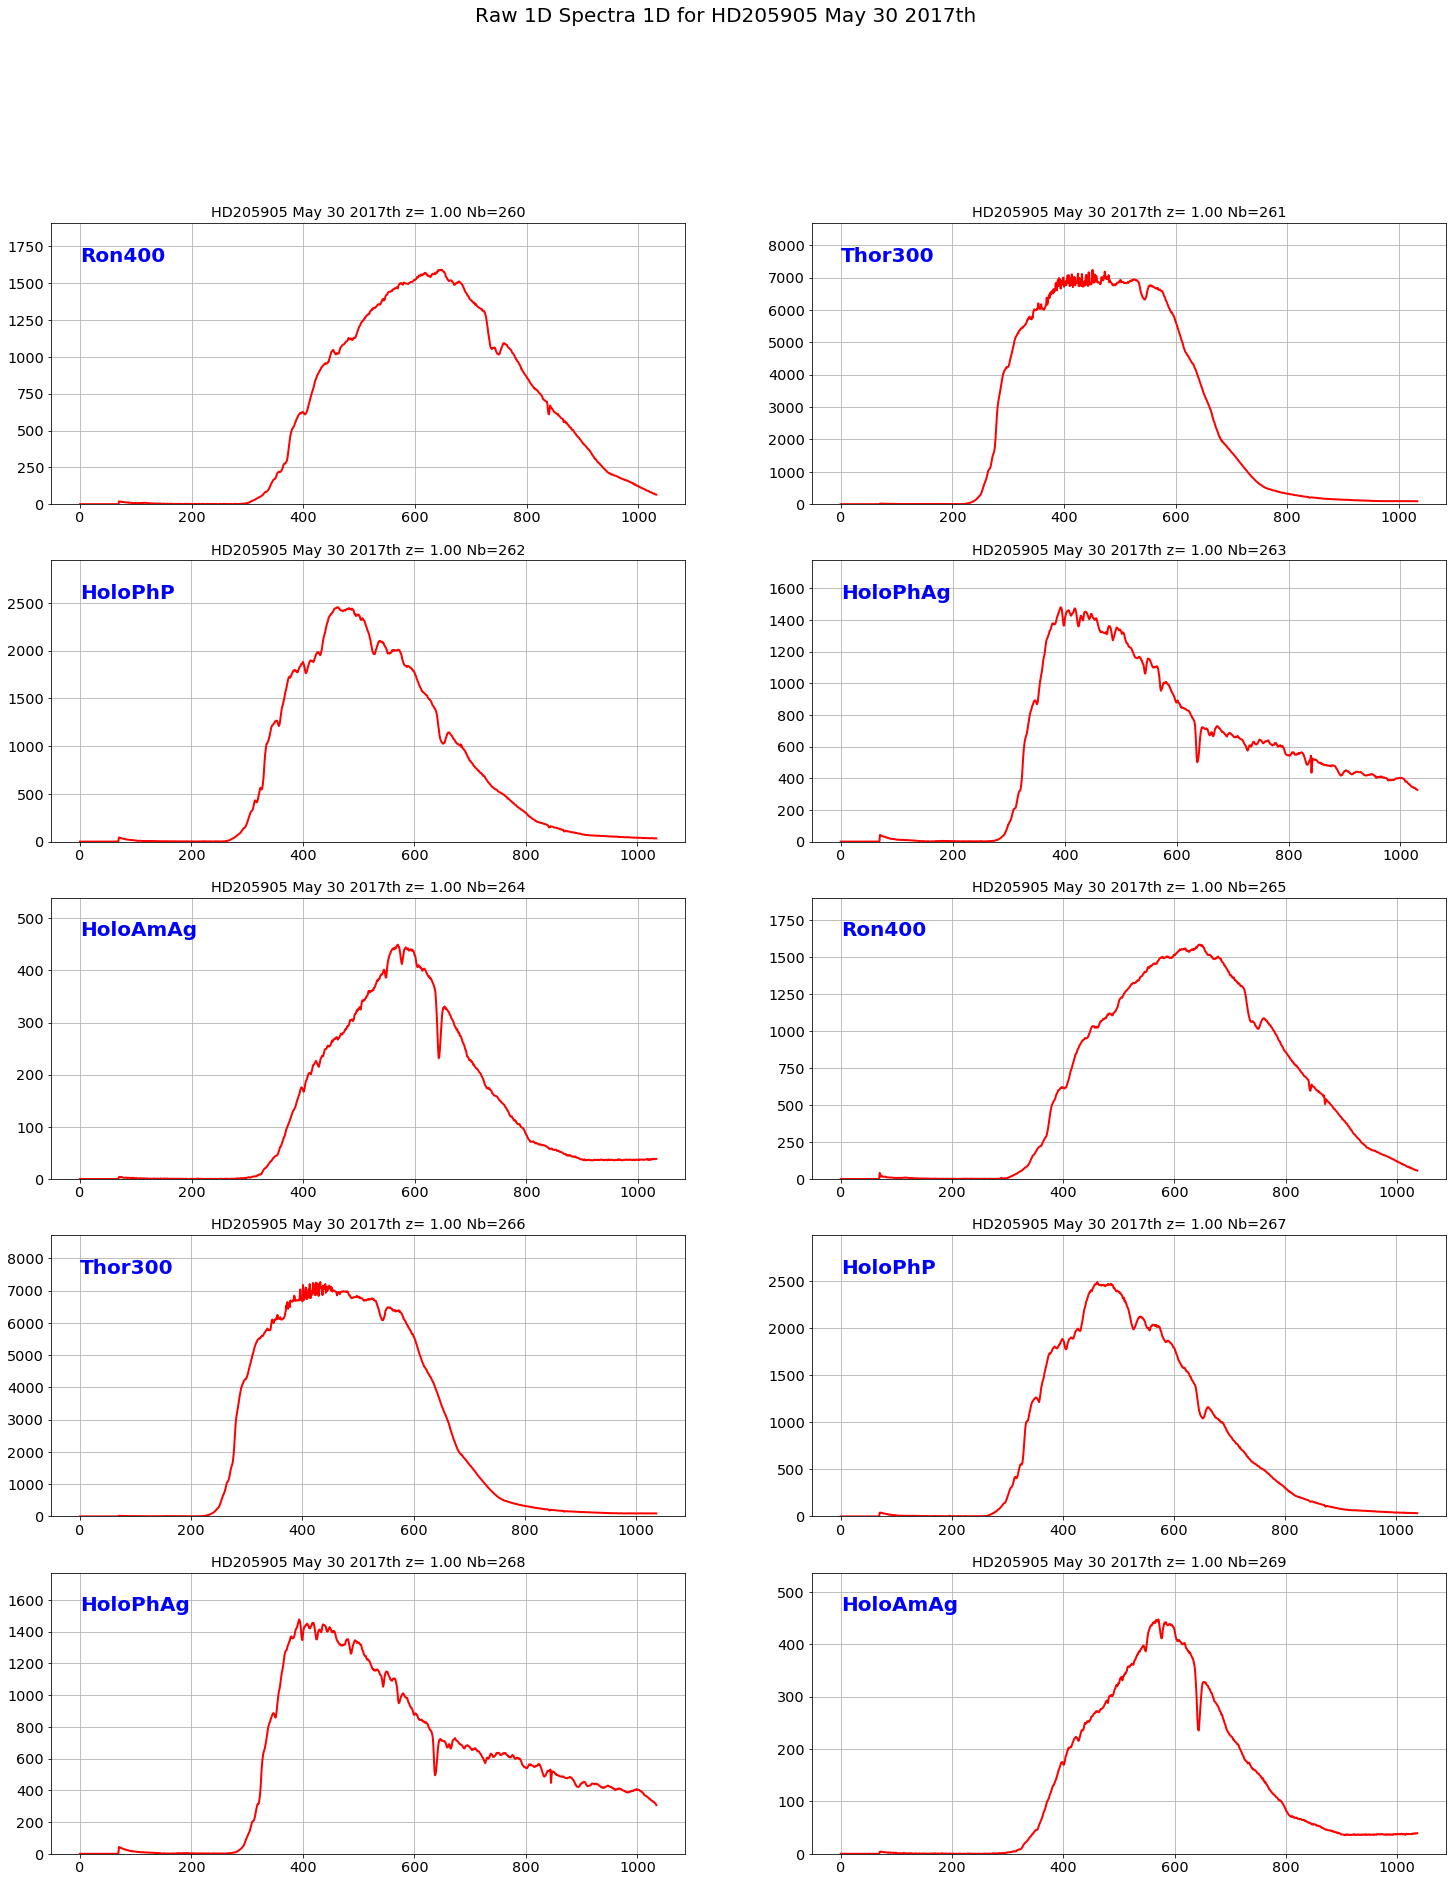

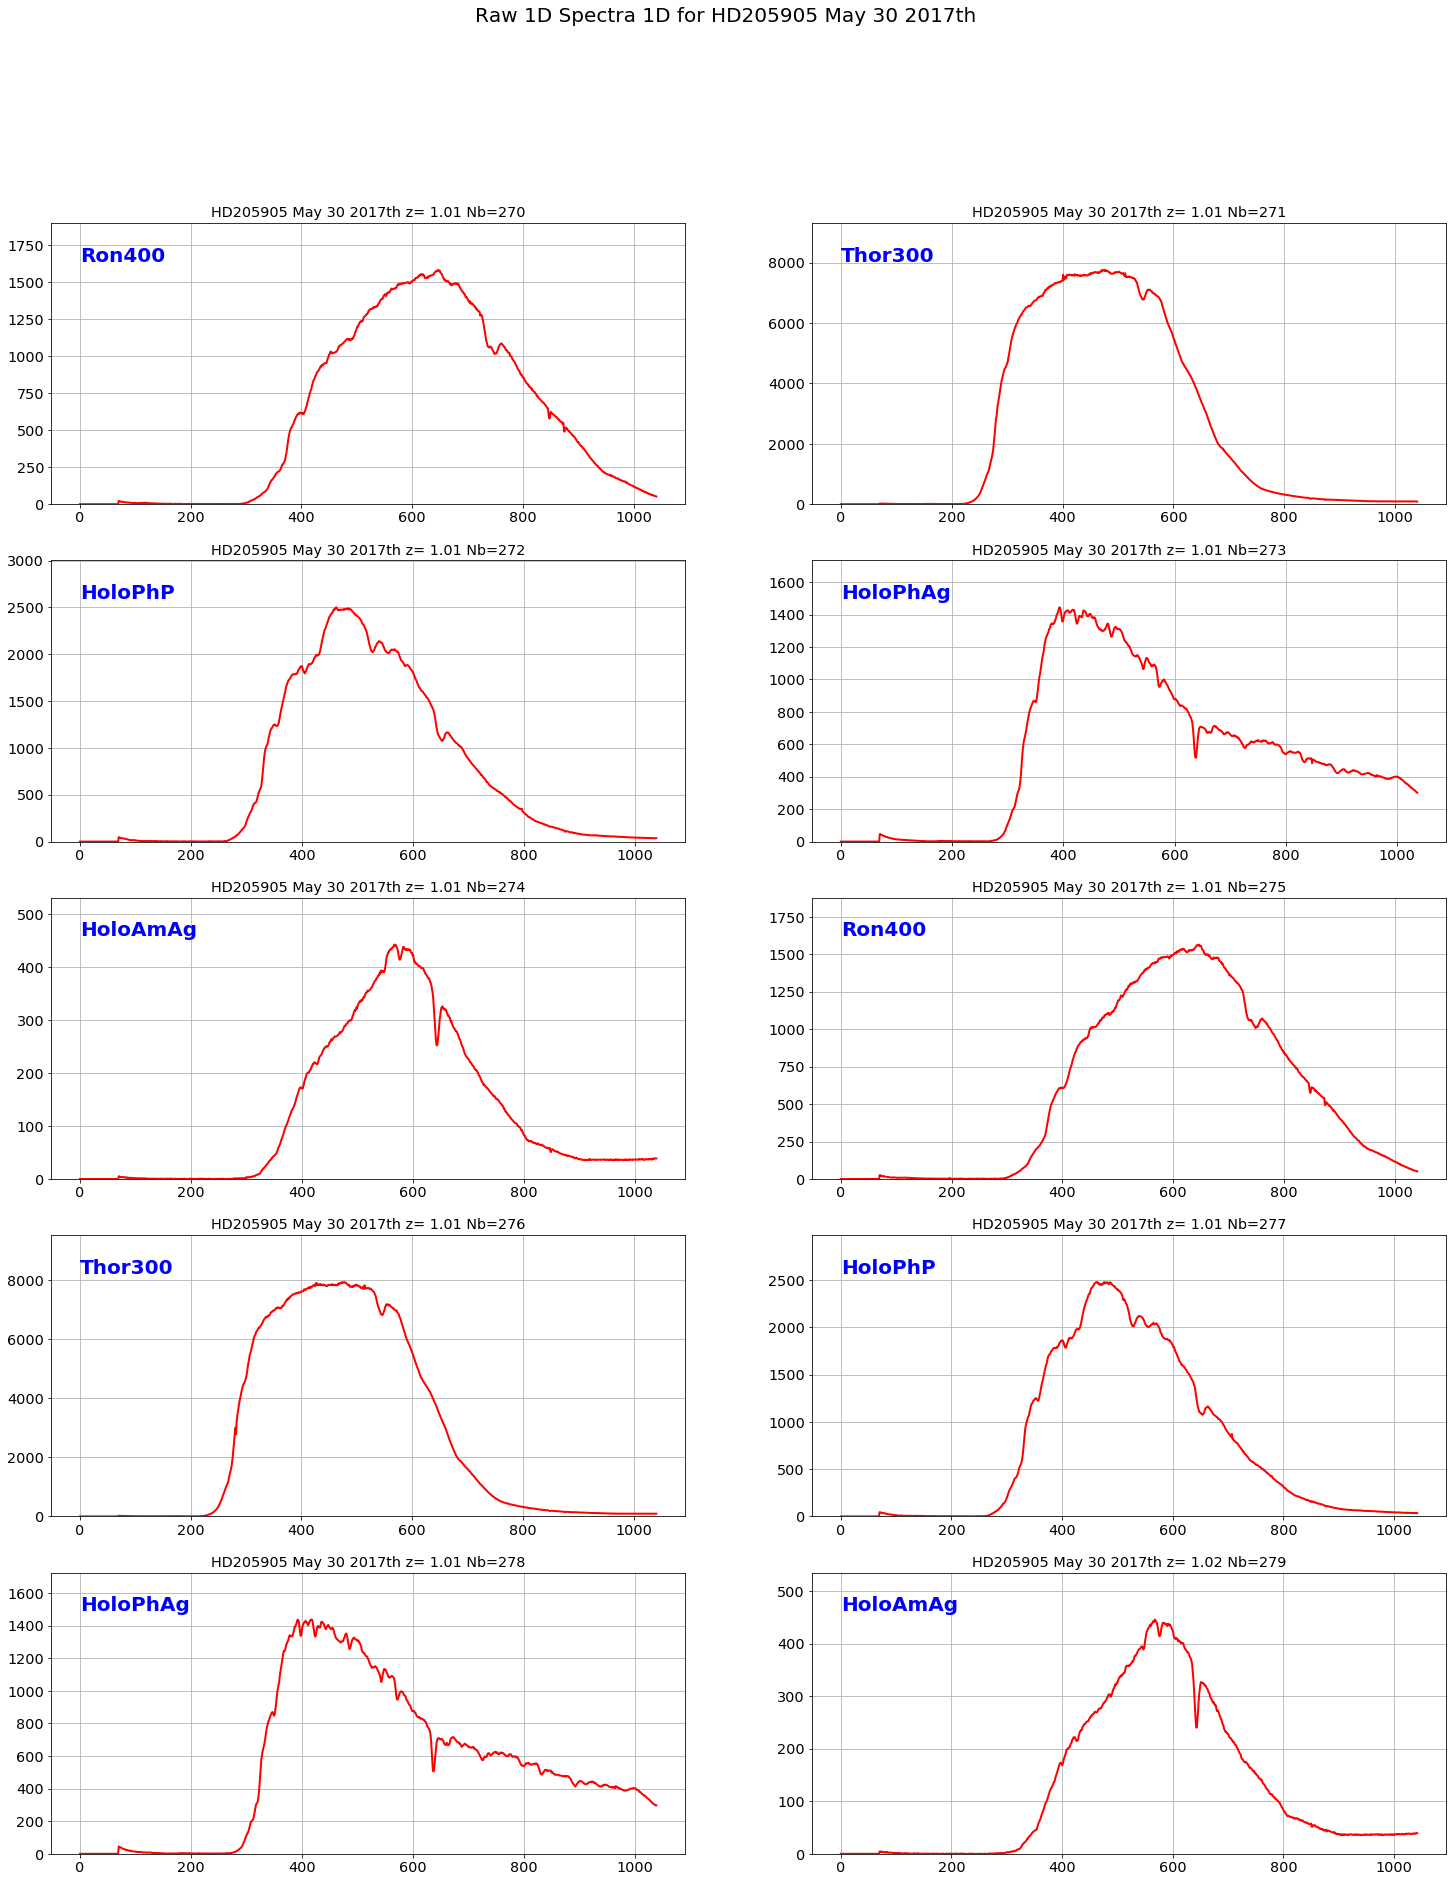

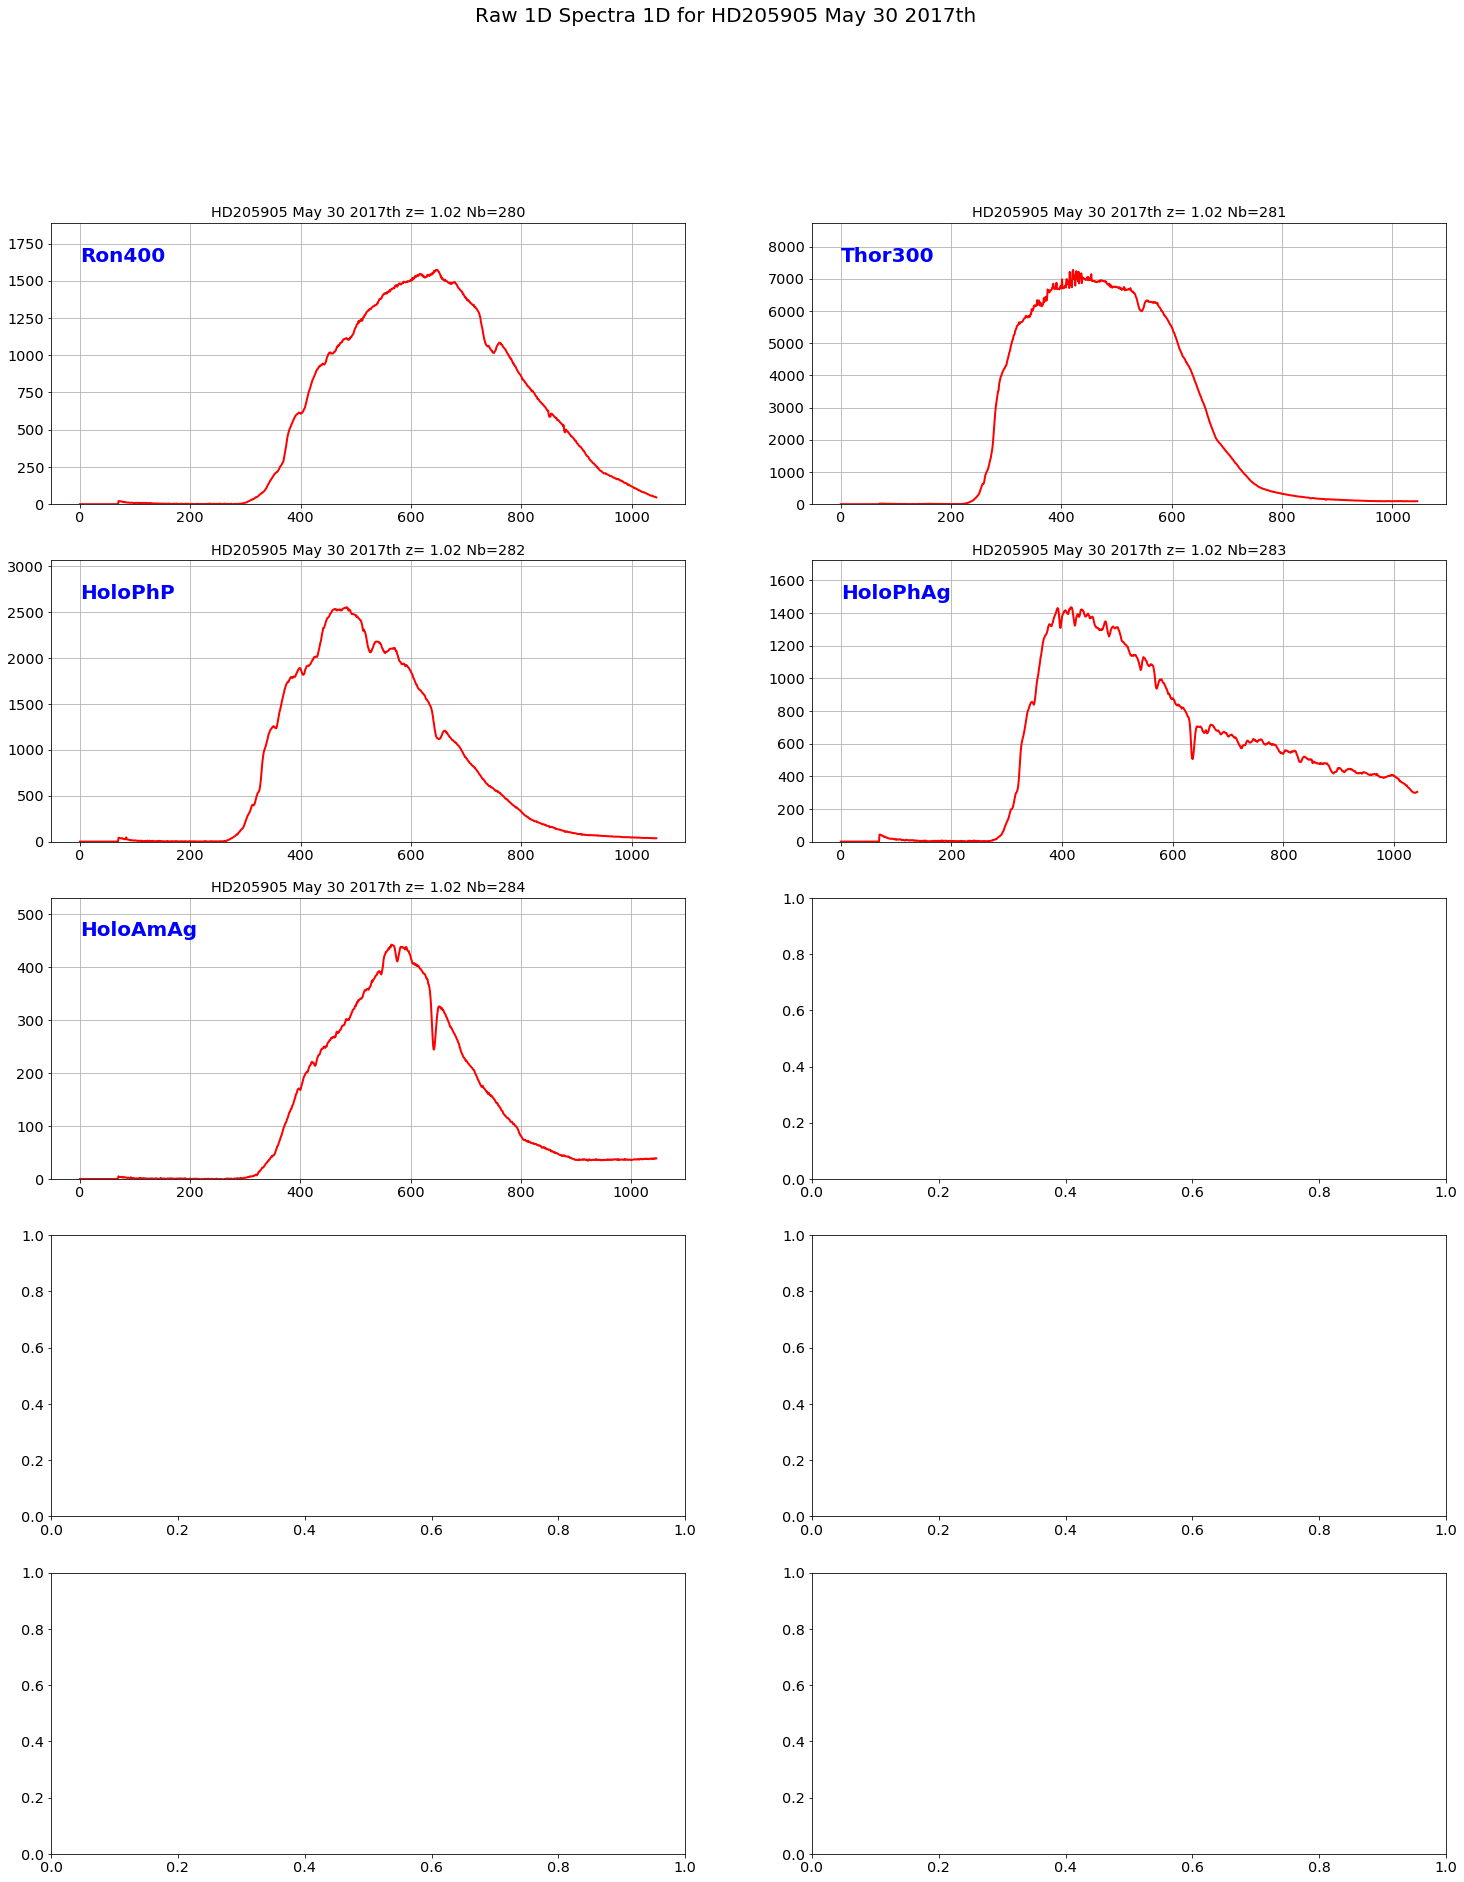

In [43]:
ShowSpectra(all_rightspectra,all_titles,object_name,dir_top_images,all_filt,'raw1Dspectra_right.pdf')

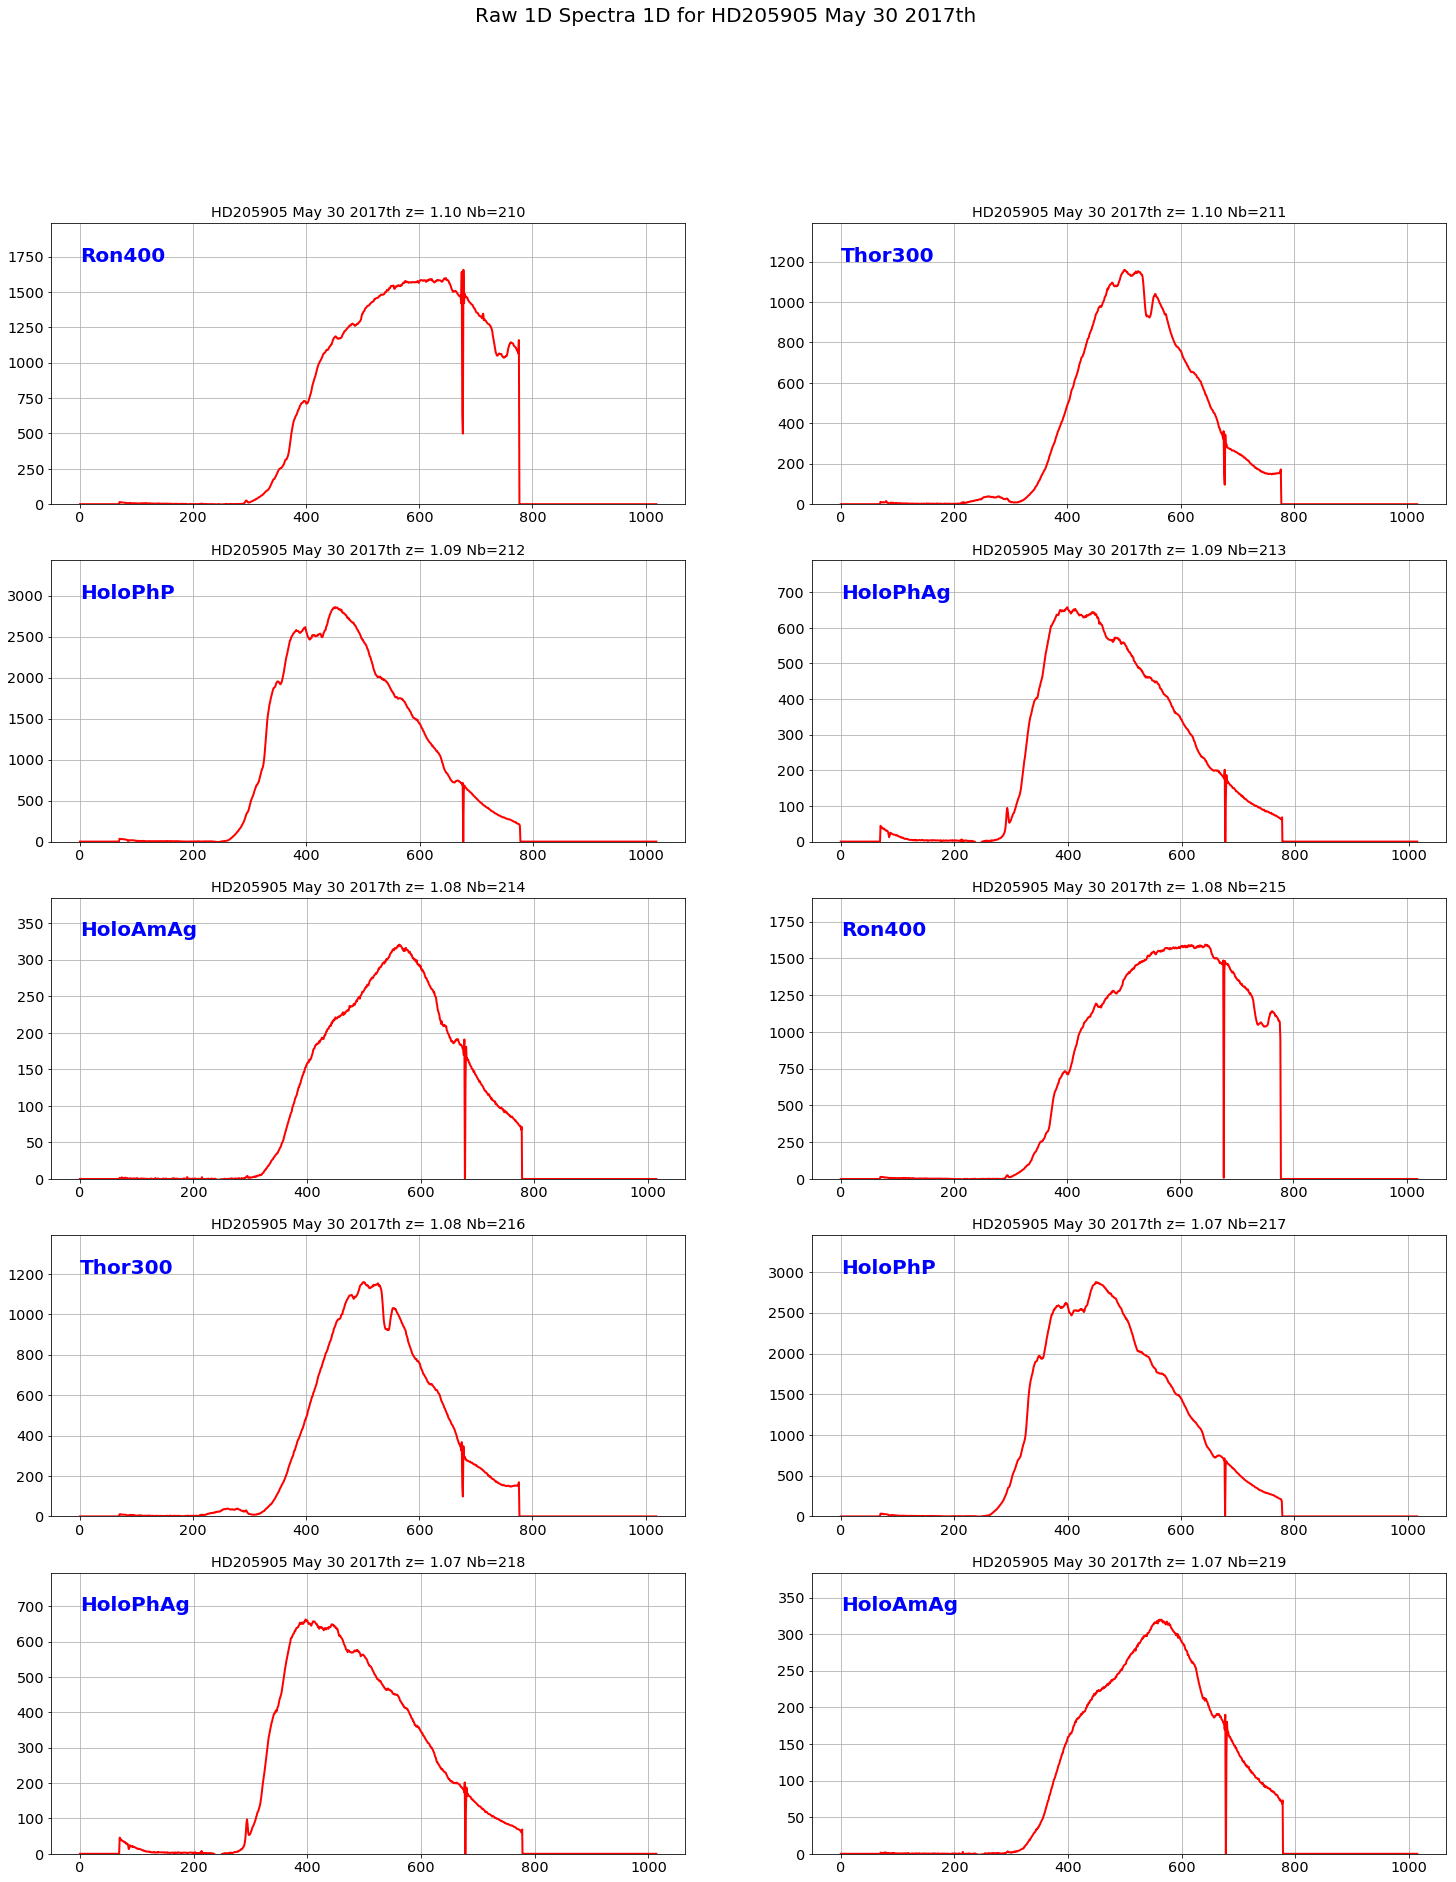

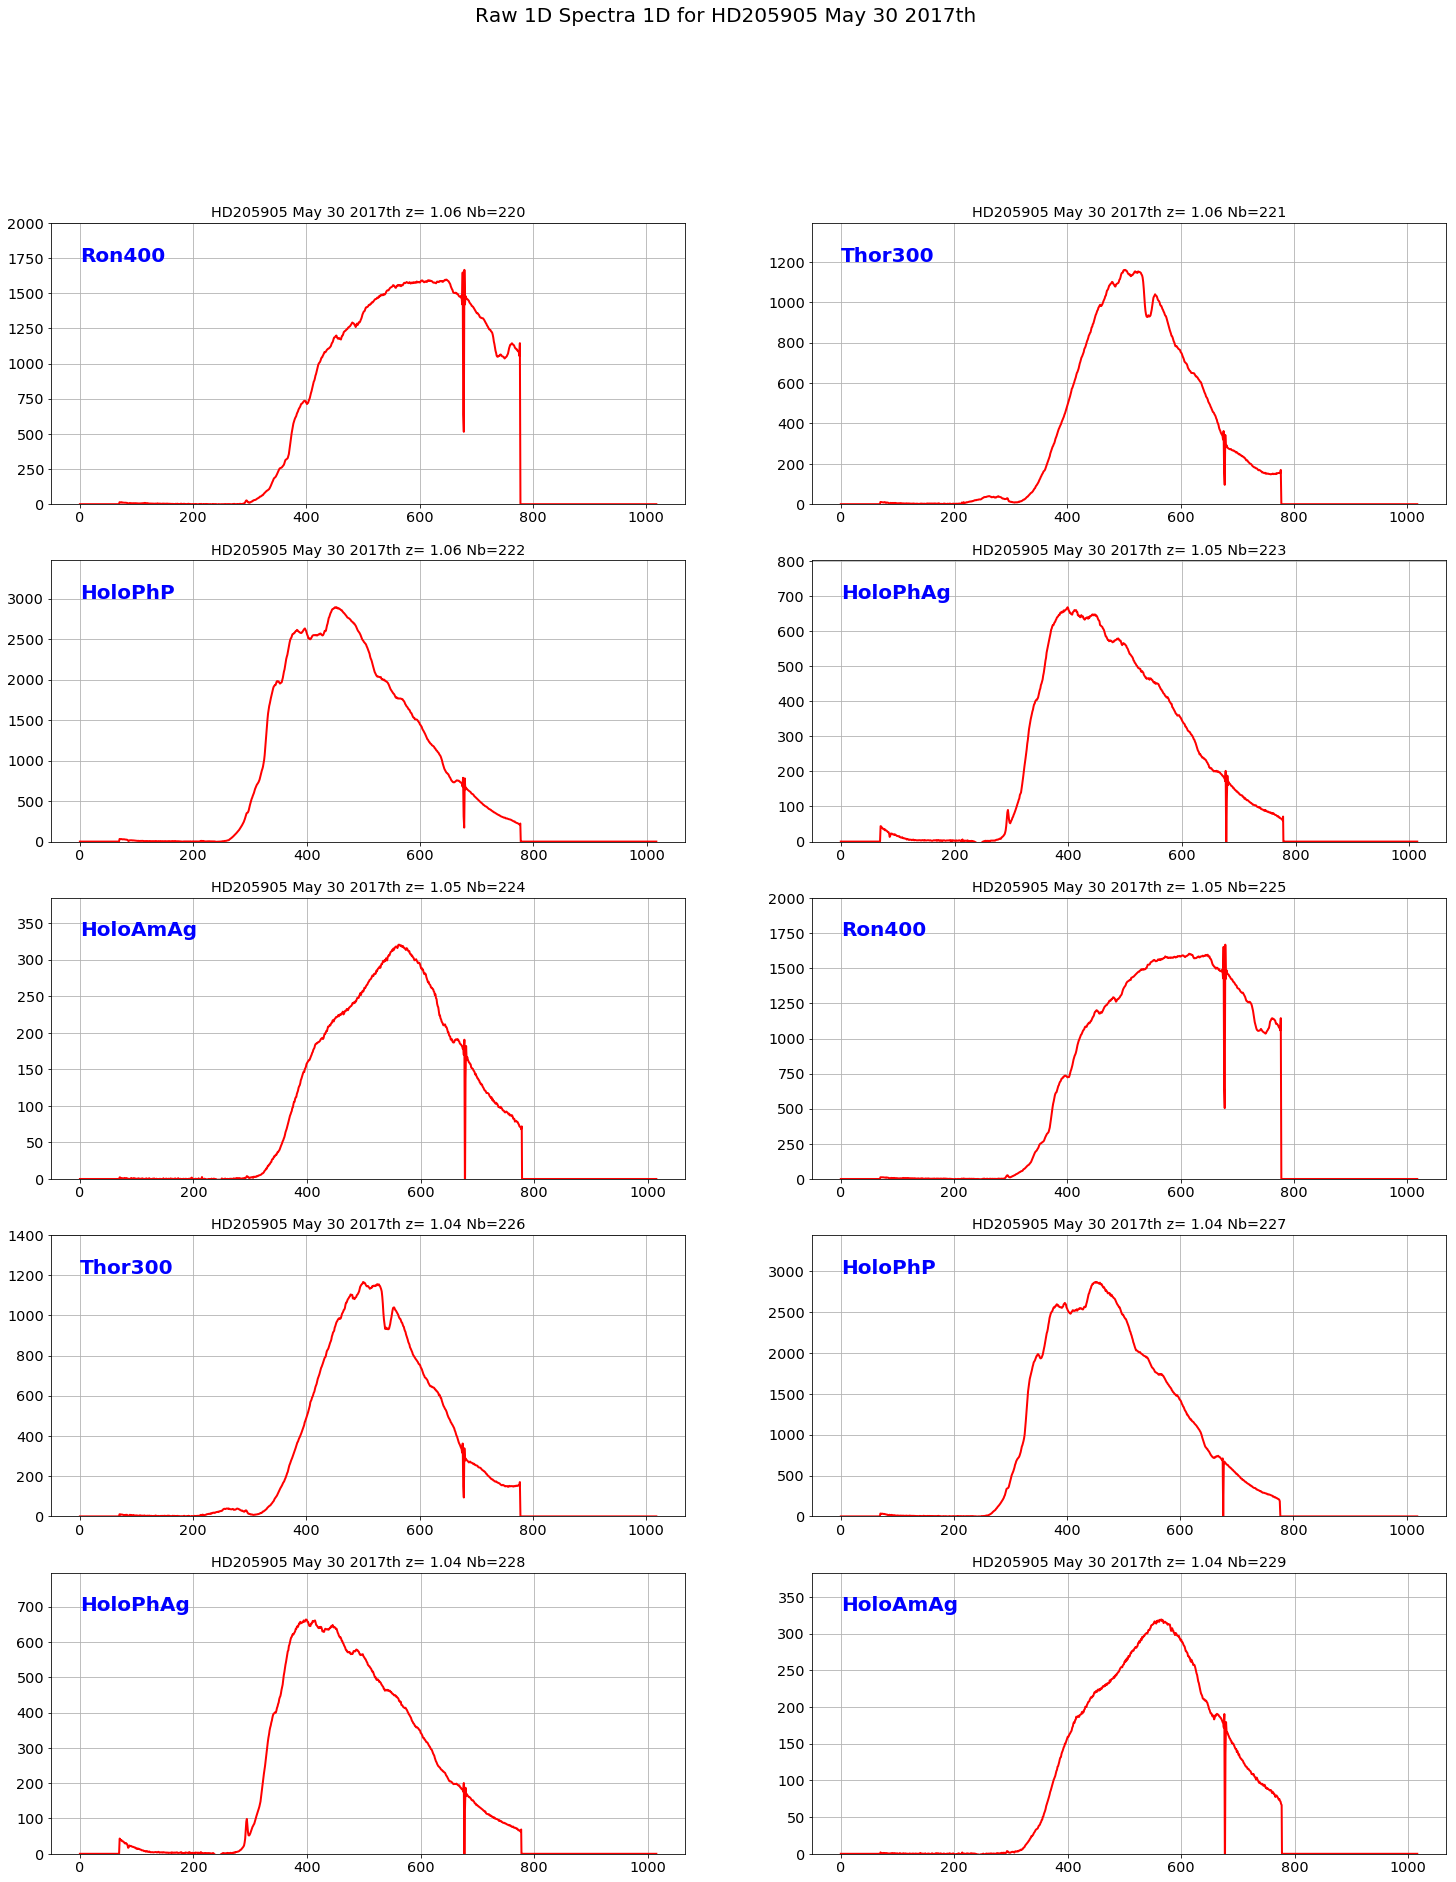

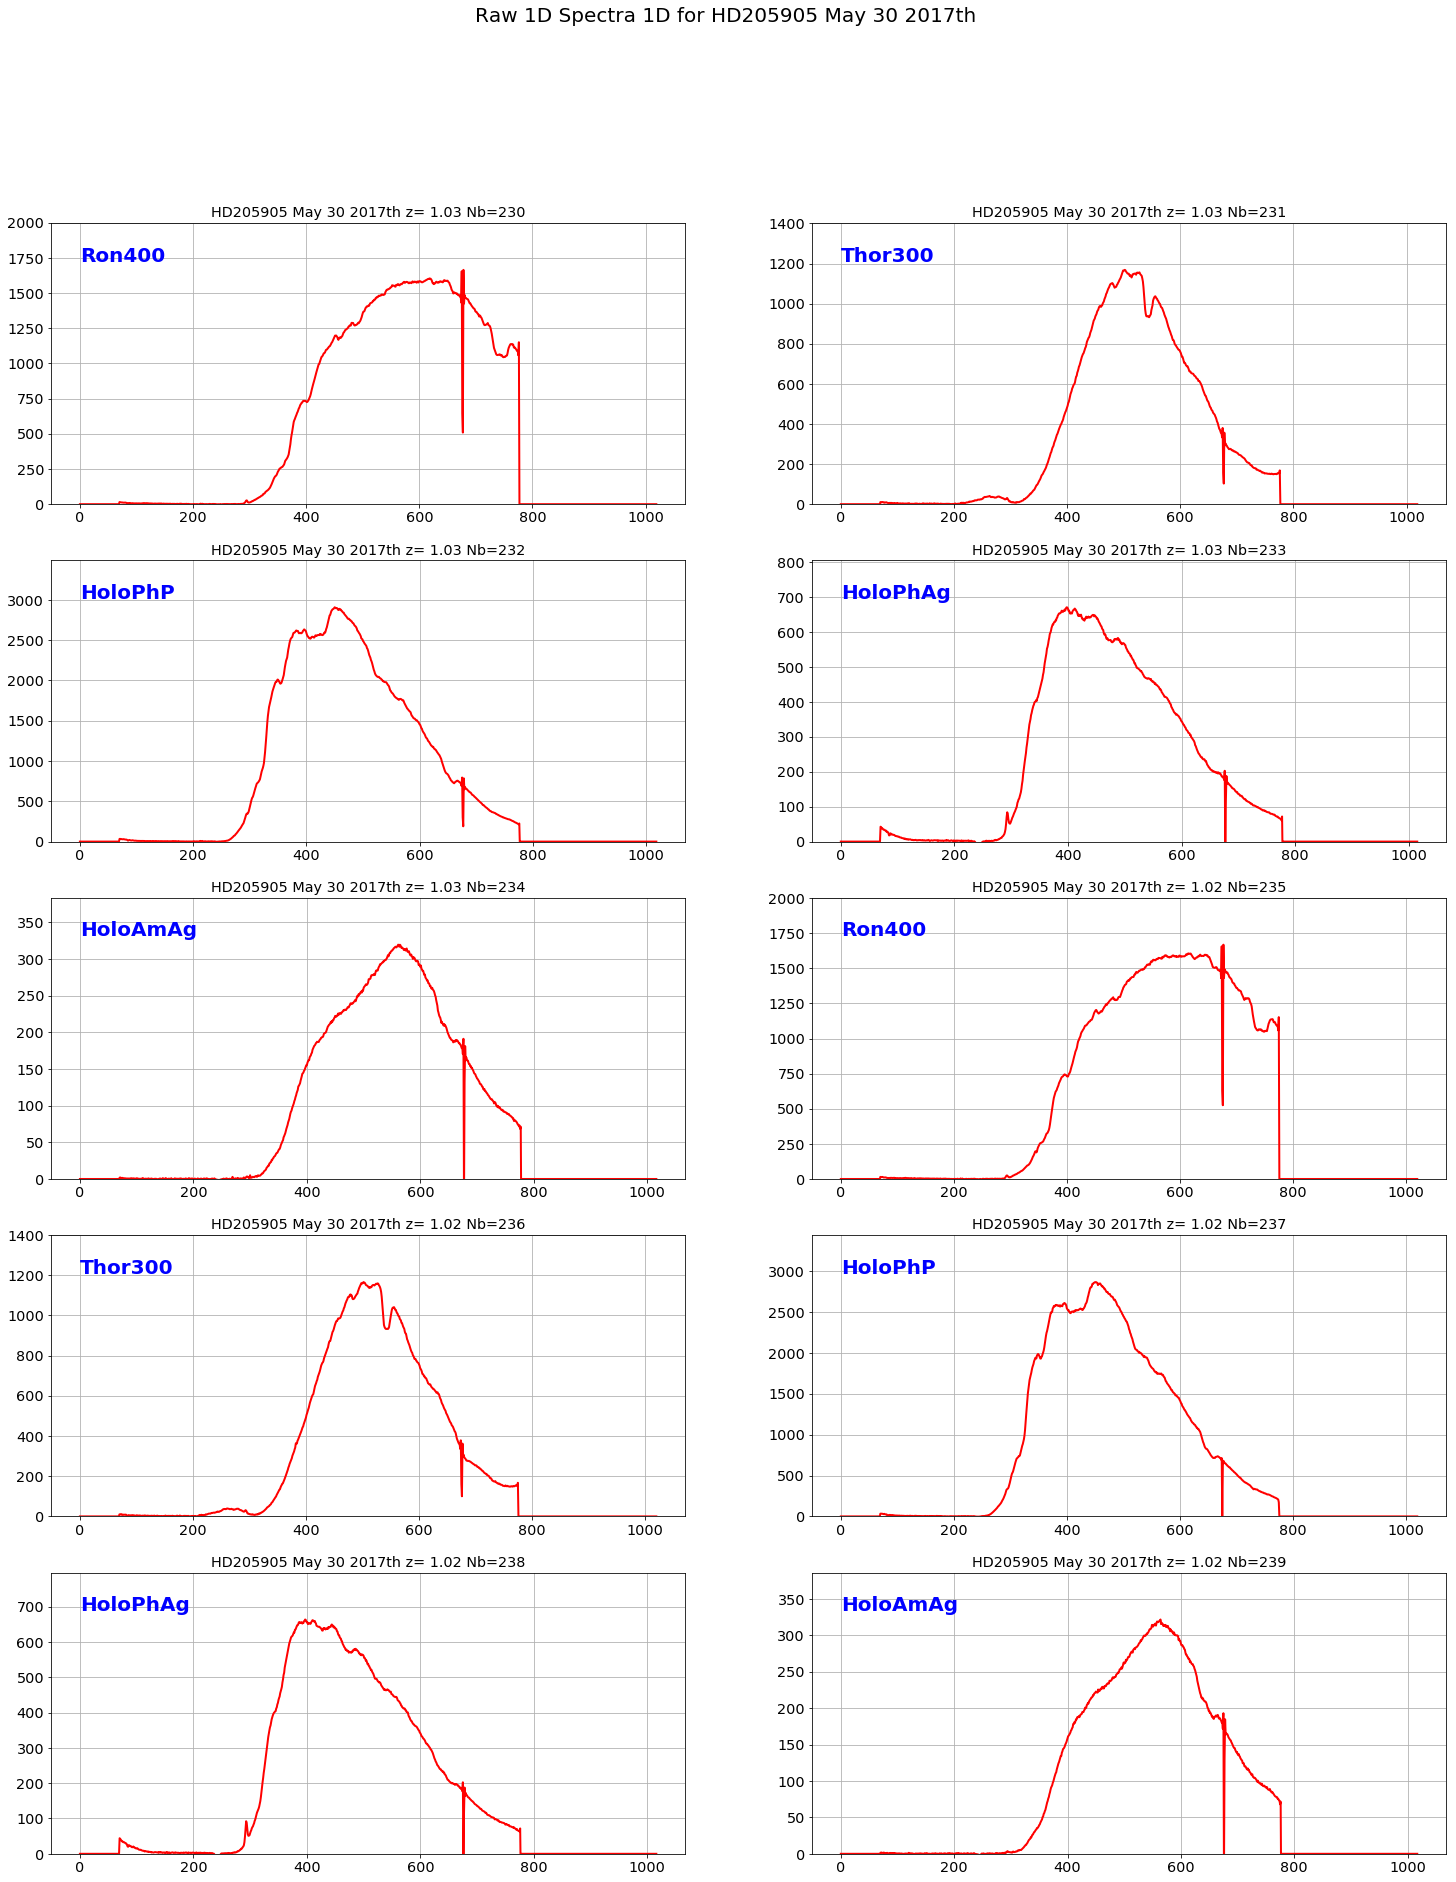

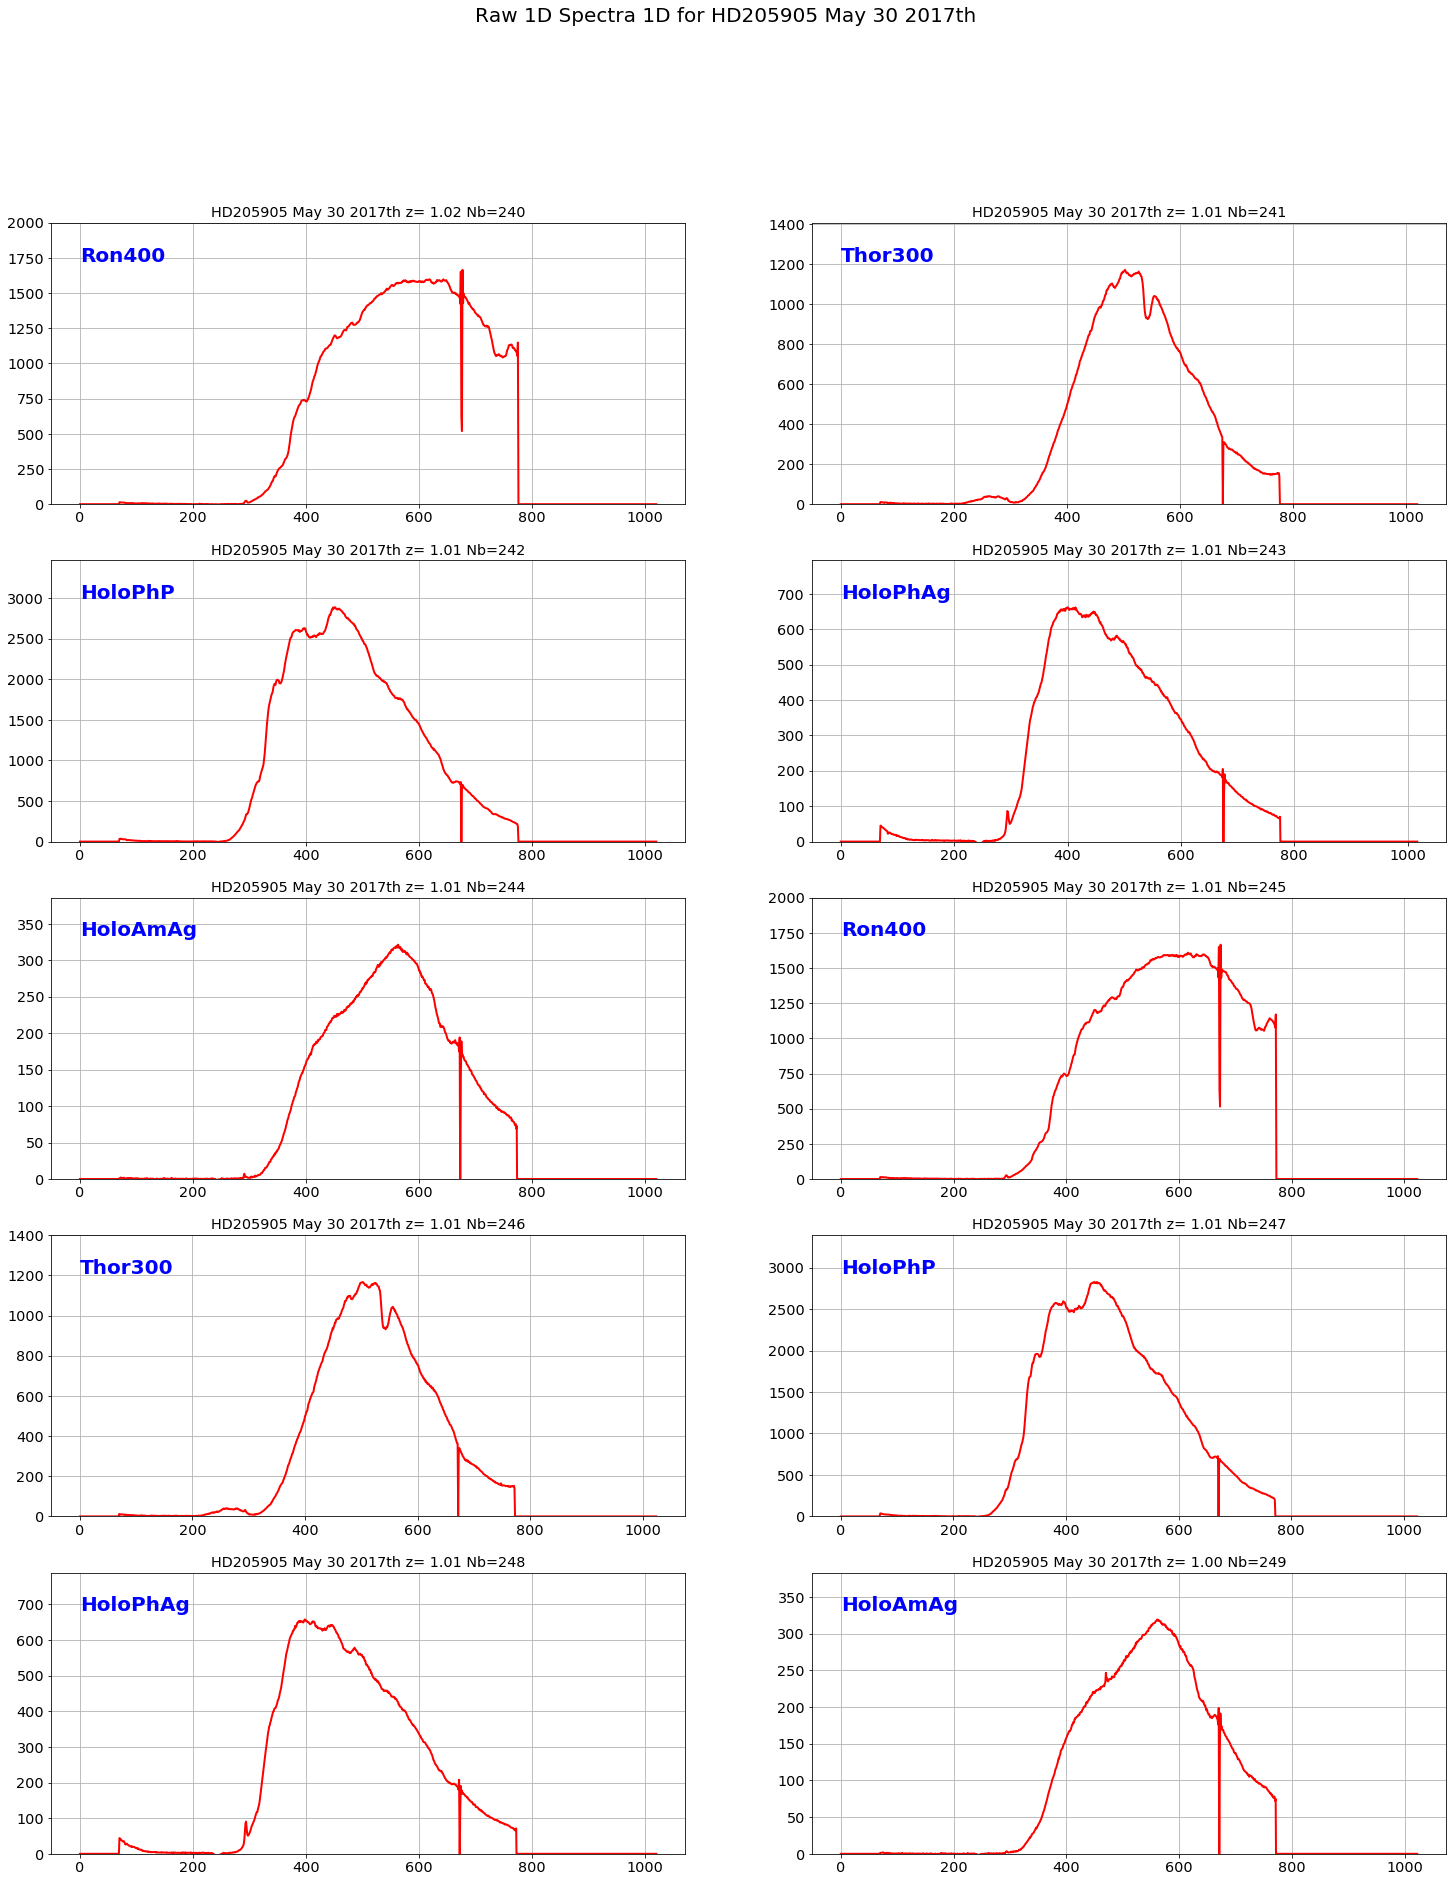

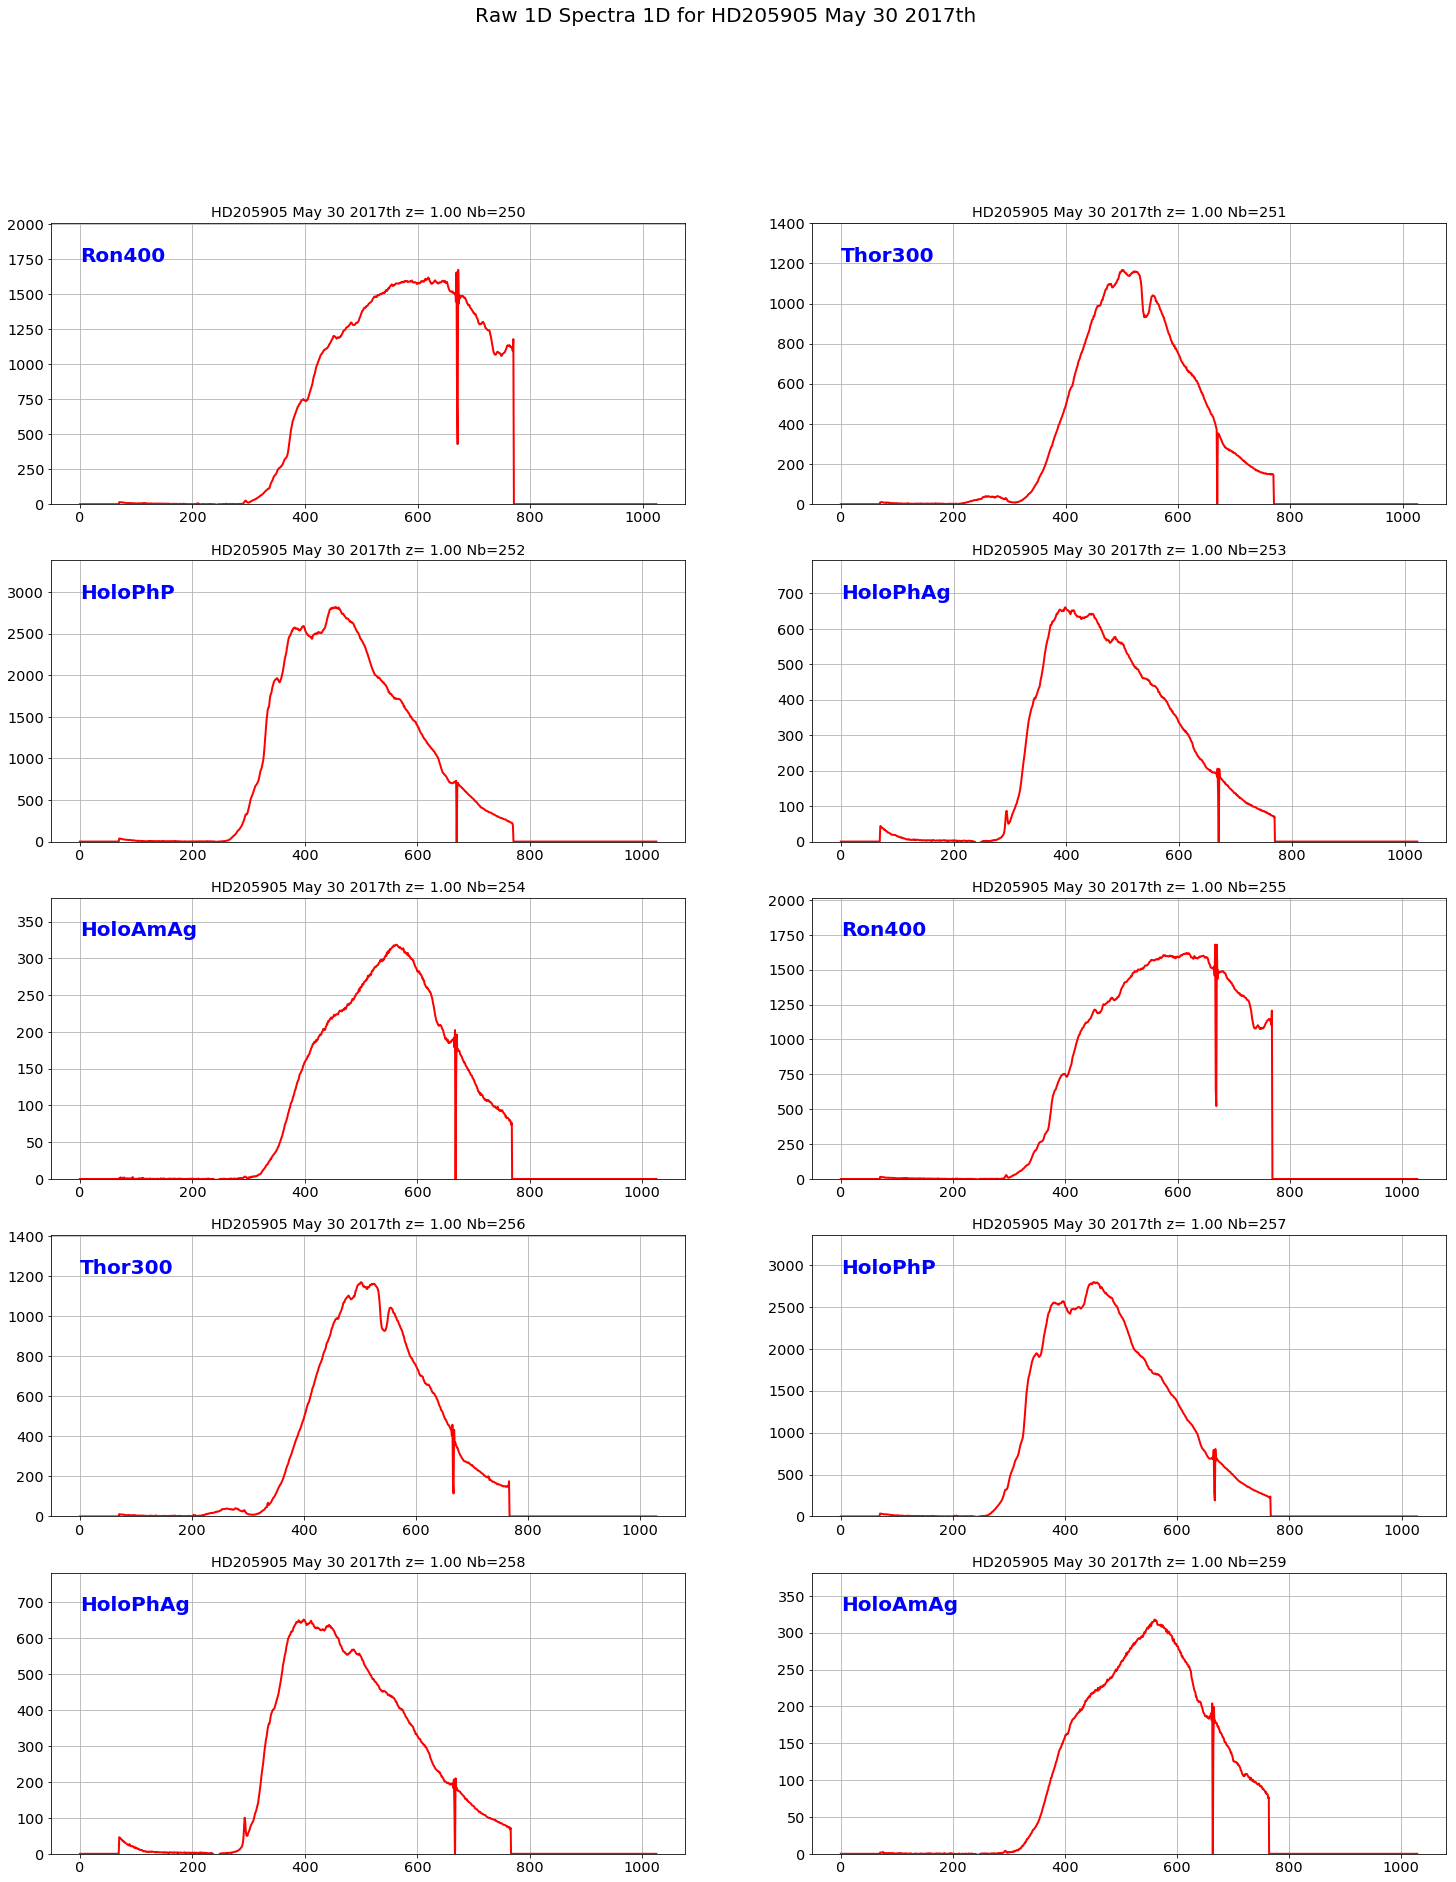

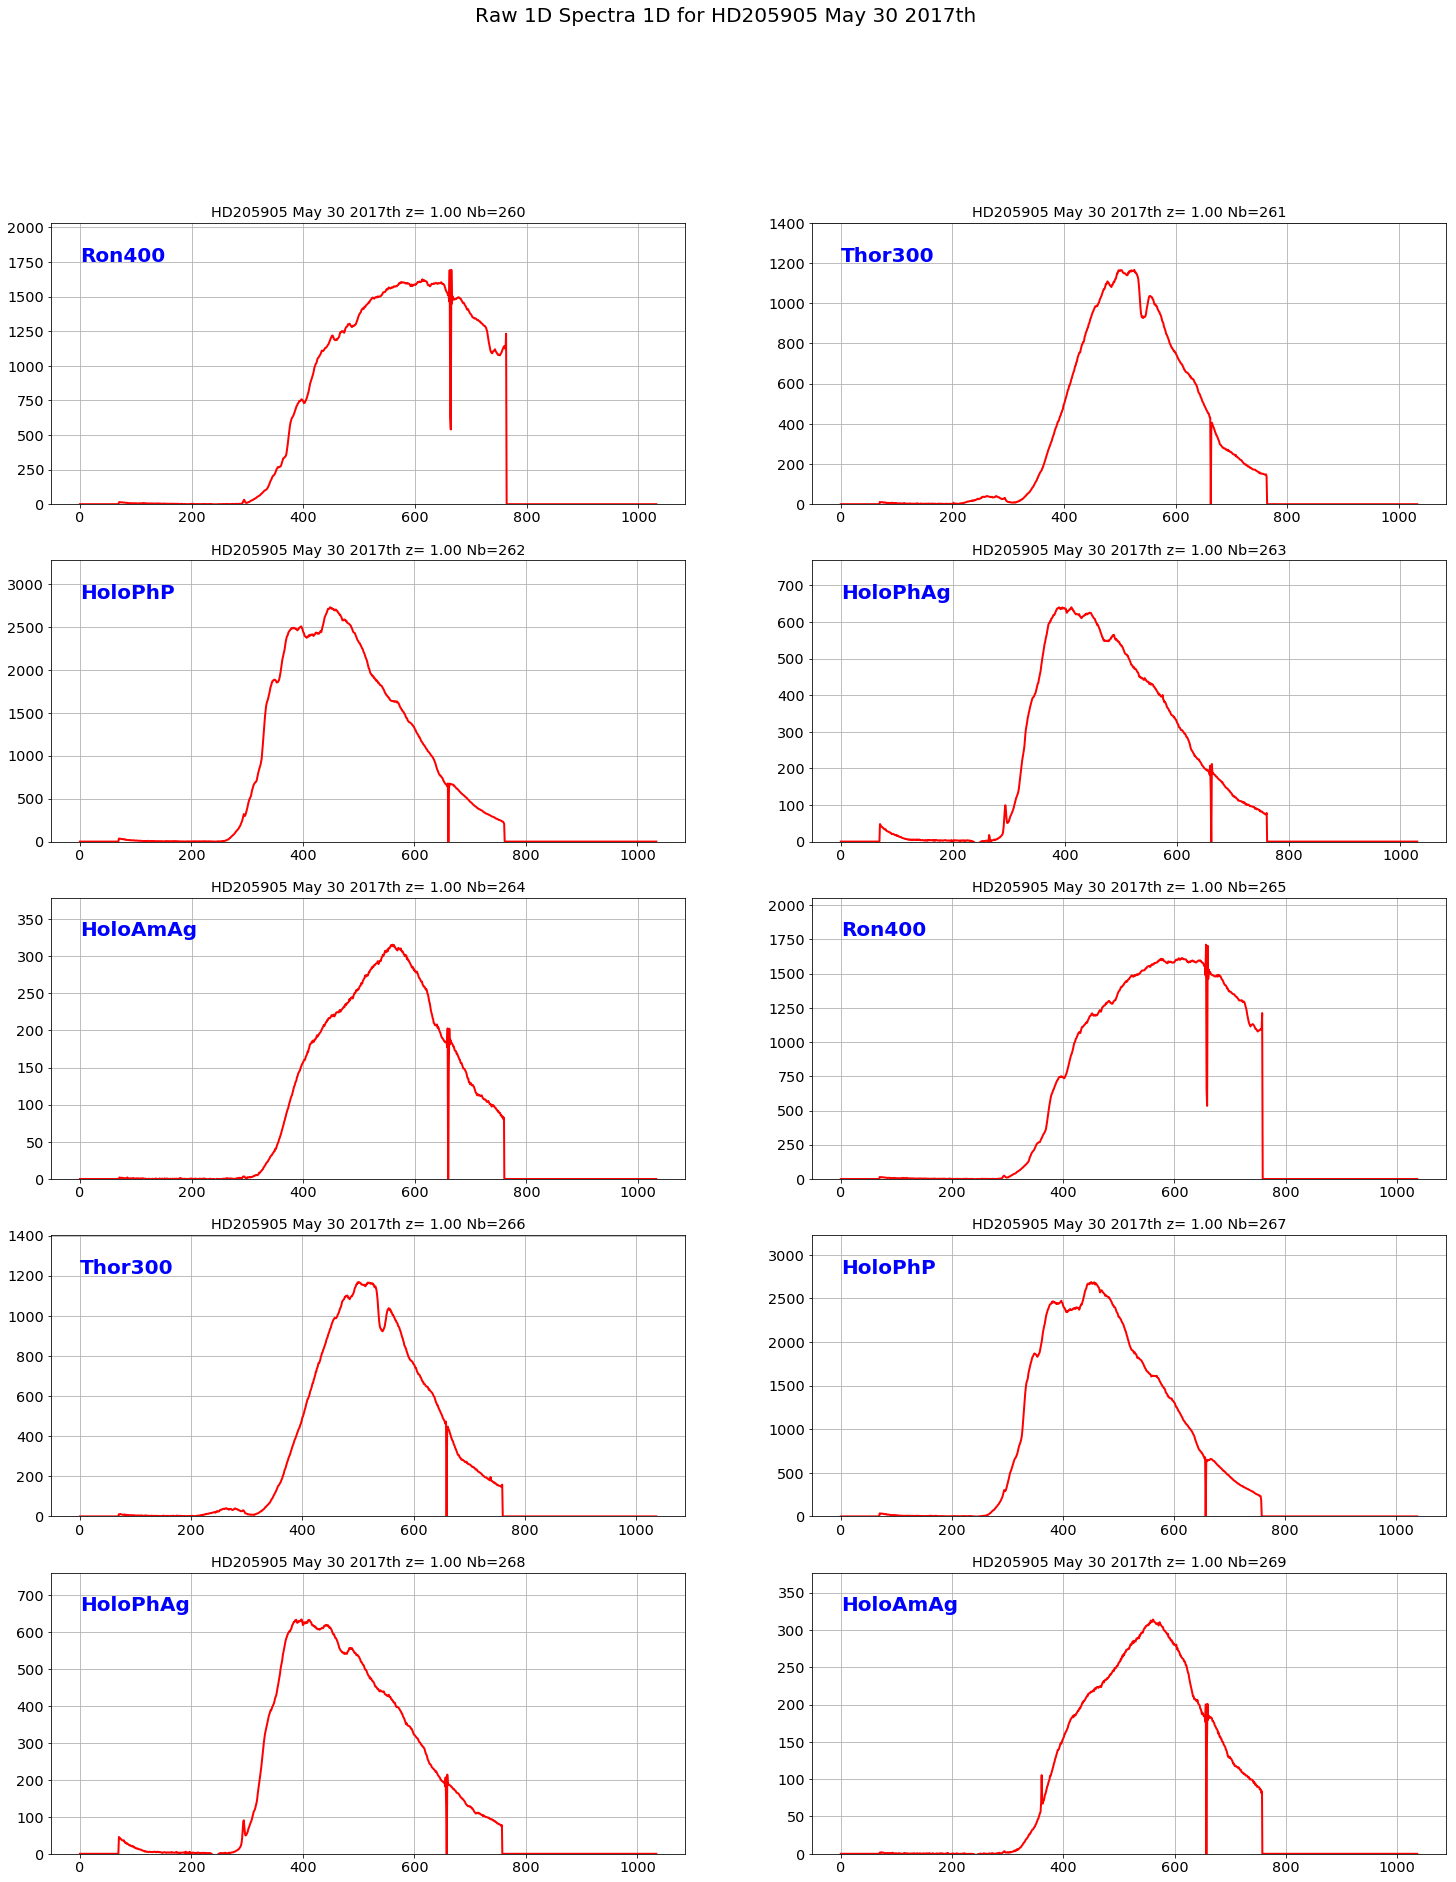

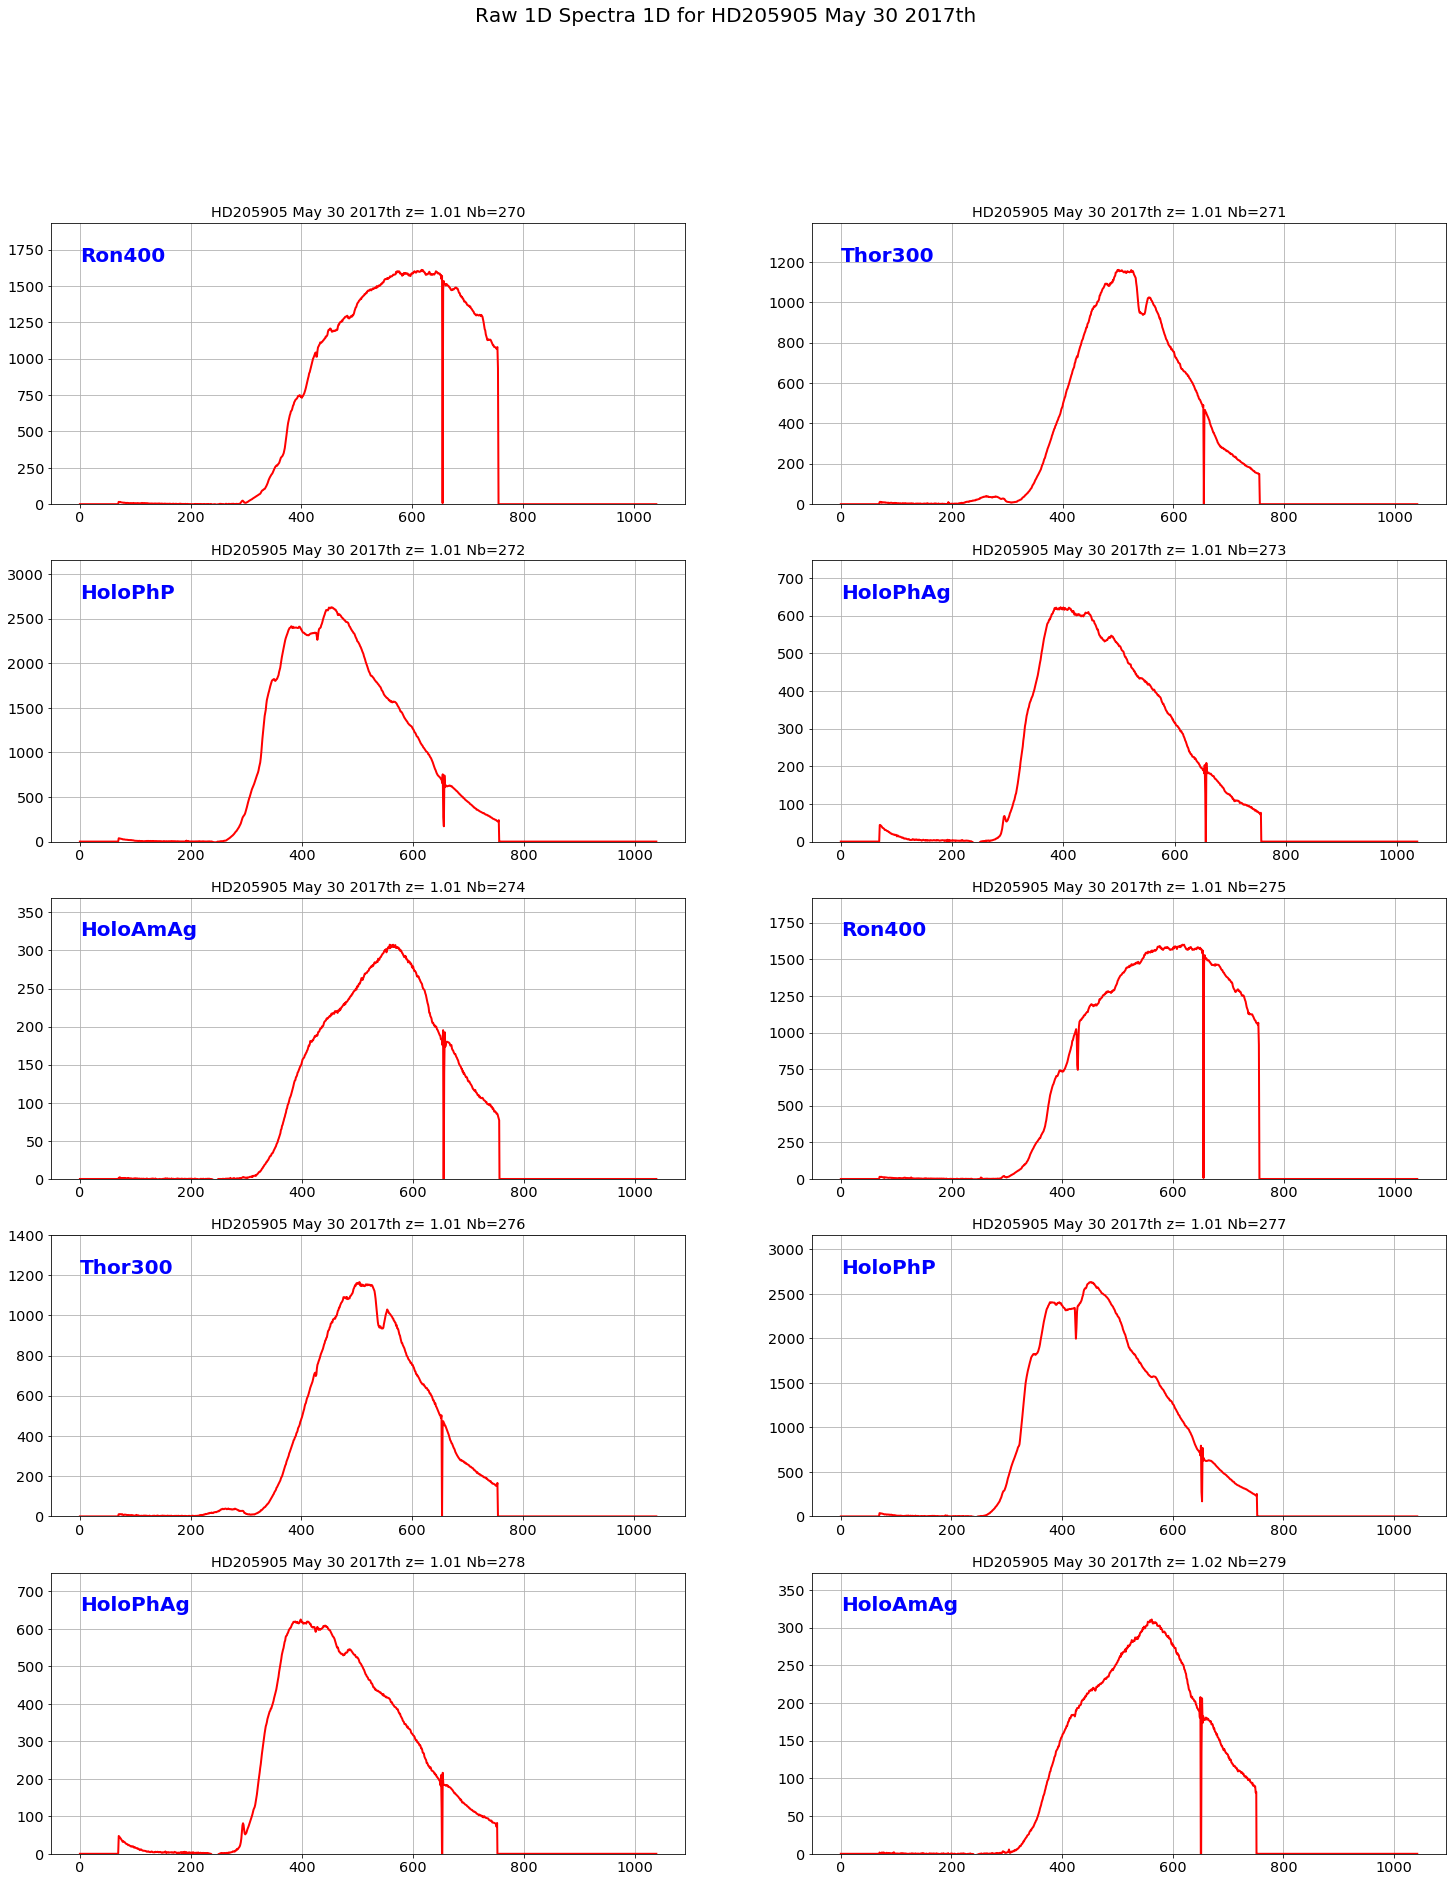

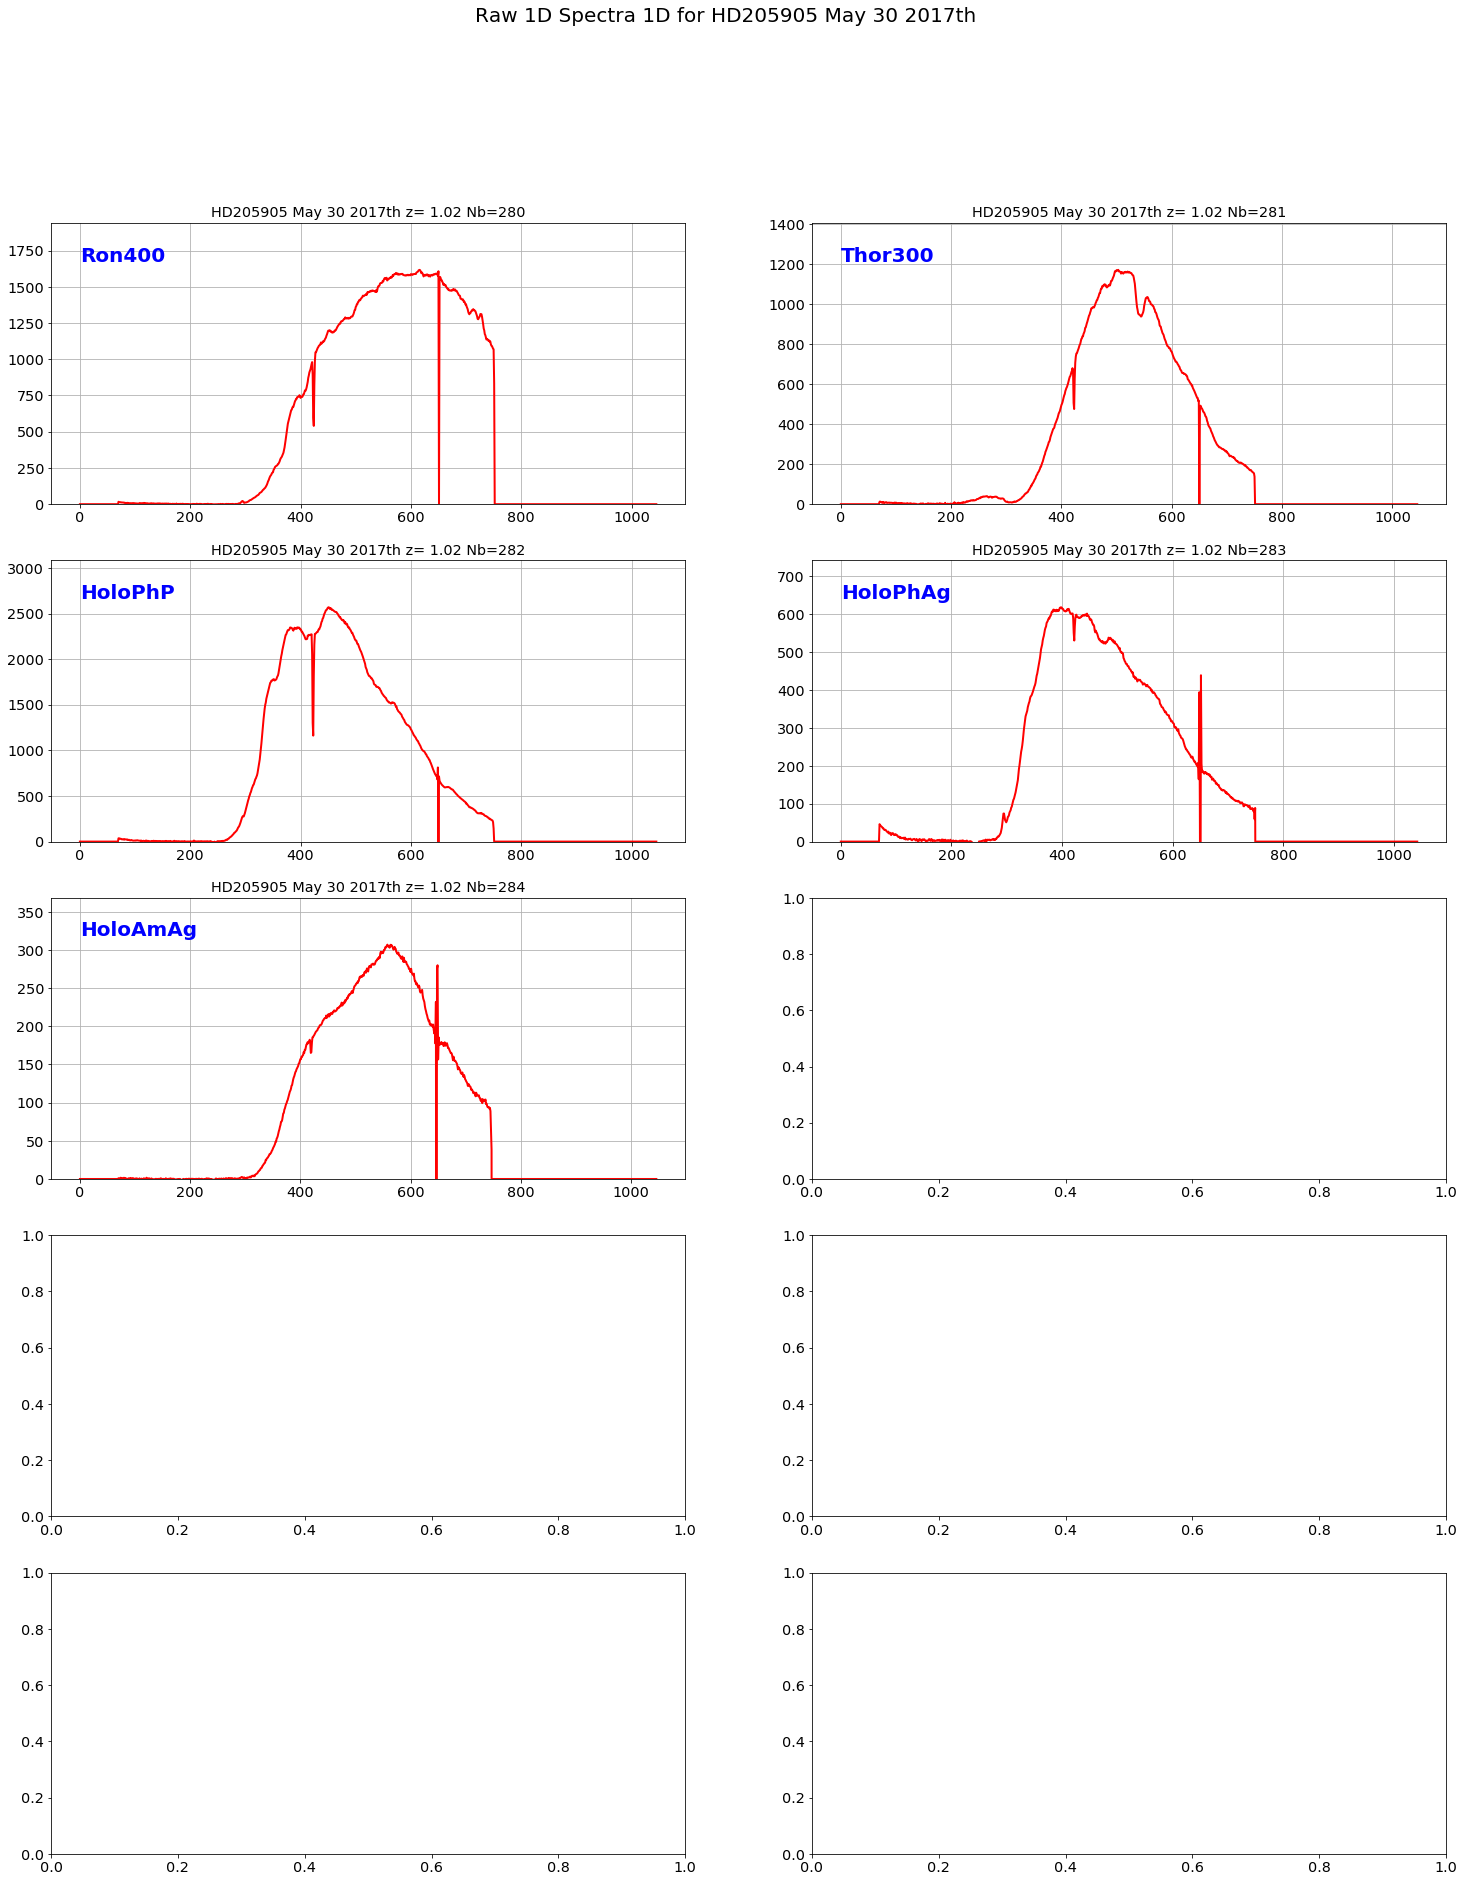

In [44]:
ShowSpectra(all_leftspectra,all_titles,object_name,dir_top_images,all_filt,'raw1Dspectra_left.pdf')

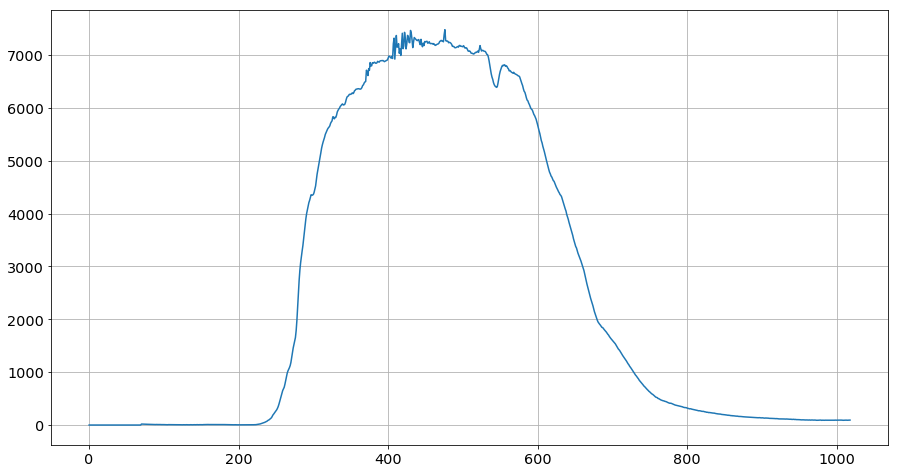

In [45]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[1])
#plt.xlim(0,500)
plt.grid(True)

## Calibrate in wavelength

In [46]:
from holo_specs import *

In [47]:
#%%cython
%load_ext autoreload
%autoreload 2
#import numpy as np
#import matplotlib.pyplot as plt
#import os

from holo_specs import *

def CALSPECAbsLineIdentification(spectra,redshift,all_titles,object_name,dir_top_images,all_filt,figname,tagname):
    """
    CALSPECAbsLineIdentification show the right part of spectrum with identified lines
    =====================
    """
    
    
    NBSPEC=len(spectra)
    NBIMGPERROW=2
    
    MAXIMGROW=max(2,int(m.ceil(float(NBSPEC)/float(NBIMGPERROW))))
    
    
    # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_images,figname)
   
    pp = PdfPages(figfilename) # create a pdf file
    
    
    title='WL calibrated 1D Spectra 1D for {} {}'.format(object_name,tagname)
    
    
    all_wl= []  # containers for wavelength
    
    ###############################
    left_cut = 0
    right_cut = 1800
    ################################
    
    
    for index in np.arange(0,NBSPEC):
        
             
        # new pdf page    
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20)
            
        # index of image in the pdf page    
        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
        
        
        
        spec = spectra[index]
        ######## convert pixels to wavelengths #########
        print '-----------------------------------------------------'
        print all_filt[index]
        holo = Hologram(all_filt[index])
        print '-----------------------------------------------------'
        #pixels = np.arange(left_cut,right_cut,1)
        pixels = np.arange(left_cut,left_cut+spec.shape[0],1)
        lambdas = holo.grating_pixel_to_lambda(pixels)
        
        all_wl.append(lambdas)
        
        axarr[iy,ix].plot(lambdas,spec,'r-',lw=2,label=tagname)
    
        ######## plot QSO emission lines ############
        axarr[iy,ix].plot([HALPHA*(1+redshift),HALPHA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\alpha$')
        axarr[iy,ix].plot([HBETA*(1+redshift),HBETA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\beta$')
        axarr[iy,ix].plot([HGAMMA*(1+redshift),HGAMMA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\gamma$')
        axarr[iy,ix].plot([HDELTA*(1+redshift),HDELTA*(1+redshift)],[0.,spec.max()*1.2],lw=2,label='$H\\delta$')
        
        axarr[iy,ix].plot([760,760],[0.,spec.max()*1.2],lw=2,label='$O_2$')
        
        
        #plot_atomic_lines(axarr[index],spec.max()*1.2,redshift=redshift,atmospheric_lines=False)
        ######## set plot
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].text(600.,spec.max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
        axarr[iy,ix].legend(loc='best',fontsize=16)
        axarr[iy,ix].set_xlabel('Wavelength [nm]', fontsize=16)
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spec.max()*1.2)
        axarr[iy,ix].set_xlim(np.min(lambdas),np.max(lambdas))
    
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
    
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()   
   
    return all_wl


In [48]:
redshift=0

In [ ]:
all_wl_right=CALSPECAbsLineIdentification(all_rightspectra,redshift,all_titles,object_name,dir_top_images,all_filt,'CALSPEC_rightspectrum.pdf','spec data ord +1')

-----------------------------------------------------
Ron400
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = nan +/- nan grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
-----------------------------------------------------
Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = nan +/- nan grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 531.21 pi

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1901 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 190228502x1882 pixels is too large. It must be less than 2^16 in each direction.

In [ ]:
all_wl_left=CALSPECAbsLineIdentification(all_leftspectra,redshift,all_titles,object_name,dir_top_images,all_filt,'CALSPEC_leftspectrum.pdf','spec data ord -1')

-----------------------------------------------------
Ron400
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = nan +/- nan grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
-----------------------------------------------------
Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = nan +/- nan grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 531.21 pi

### Save outputfilename
Results of the fits for right and left spectra are saved as images

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra_(.*)',short_infilename)
    short_outfilename='calibSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [ ]:
newfullfilenames[0:5]

In [ ]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='CalibLeftSpecWL',format='E',array=all_wl_left[idx[0]])
    col2=fits.Column(name='CalibLeftSpec',format='E',array=all_leftspectra[idx[0]])
    #col3=fits.Column(name='CalibLeftSpecFitParam',format='E',array=fitparam_leftspectra[idx[0]])
    col4=fits.Column(name='CalibRightSpecWL',format='E',array=all_wl_right[idx[0]])
    col5=fits.Column(name='CalibRightSpec',format='E',array=all_rightspectra[idx[0]])
    #col6=fits.Column(name='CalibRightSpecFitParam',format='E',array=fitparam_rightspectra[idx[0]])
    #cols=fits.ColDefs([col1,col2,col3,col4,col5,col6])
    cols=fits.ColDefs([col1,col2,col4,col5])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,overwrite=True)

In [ ]:
!ls -l ./spectrum_calibspec